In [1]:
from __future__ import print_function, division
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import datetime

KeyboardInterrupt: 

In [ ]:
tf.__version__
[*tf.config.list_physical_devices()]
# %pip install tensorflow-metal

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

2025-04-08 17:19:44.245586: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-08 17:19:44.245620: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


ShapeLayer: in code_PCM why value are integer not binary? if value must represent connectivity between code node(in column) and value node(in row), binary is enough to represent connectivity

GitHub Copilot: # LDPC Protograph Matrix Integer Values Explained

You're making an excellent observation. In standard LDPC codes, the parity check matrix is indeed binary (0/1). However, in this implementation, the initial `code_PCM` contains integer values for a specific reason: this is using a **protograph-based LDPC** code construction.

## Why Integer Values Instead of Binary?

The integer values in the original PCM serve a dual purpose:
- `-1`: Represents no connection between nodes
- Positive integers (1, 2, 3, etc.): Represent both a connection AND a **cyclic shift parameter**

## How These Values Are Used

1. **For Connectivity Matrices** (like `W_odd2even`, `W_even2odd`):
   ```python
   # The PCM is converted to binary (0/1)
   for i in range(0, code_PCM.shape[0]):
       for j in range(0, code_PCM.shape[1]):
           if (code_PCM[i, j] == -1):
               code_PCM[i, j] = 0  # No connection
           else:
               code_PCM[i, j] = 1  # Connection exists
   ```

2. **For Protograph Lifting** (creating the actual LDPC code):
   ```python
   # Original integer values used for cyclic shifts
   if (code_PCM1[i, j] != -1):
       Lift_num = code_PCM1[i, j] % Z_array[t]  # Get cyclic shift amount
       for h in range(0, Z_array[t], 1):
           Lift_M1[k * Z_array[t] + h, k * Z_array[t] + (h + Lift_num) % Z_array[t]] = 1
   ```

## Key Insight

The implementation maintains two versions of the matrix:
1. `code_PCM` - Binary version for neural network connectivity 
2. `Ldpc_PCM` - Original integer version for lifting operations

This is why the original matrices are kept as:
```python
Ldpc_PCM = [code_PCM0, code_PCM1, code_PCM2, code_PCM1]
```

This approach is standard in protograph LDPC codes, where the specific shift values enable creating diverse expanded matrices with good properties while maintaining a compact base representation.

ShapeLayer: what is protograph based ldpc and what does that work

GitHub Copilot: # Protograph-Based LDPC Codes: A Structured Approach to Error Correction

Protograph-based LDPC (Low-Density Parity-Check) codes are a powerful class of error-correcting codes that use a small template graph to generate larger, structured codes with excellent performance characteristics.

## What is a Protograph?

A protograph is a relatively small "blueprint" or "template" graph that defines the basic structure of the LDPC code:

- It's represented as a small base matrix (like `code_PCM0` in your code)
- Values in this matrix have dual meaning:
  - `-1`: No connection between nodes
  - Positive integers (1, 2, 3...): Both indicate a connection AND specify a shift parameter

## How Protograph-Based LDPC Codes Work

These codes are constructed through a process called "lifting" or "copy-and-permute":

1. **Start with a protograph base matrix** (small matrix with integer values)
2. **Make Z copies** of this base graph (Z is the lifting factor)
3. **Connect these copies** according to specific shift patterns defined by the integers in the protograph

In your code, this lifting process is implemented here:

```python
# For each connection in the protograph
if (code_PCM1[i, j] != -1):
    # Calculate the cyclic shift amount from the protograph value
    Lift_num = code_PCM1[i, j] % Z_array[t]
    # Create a shifted identity submatrix
    for h in range(0, Z_array[t], 1):
        Lift_M1[k * Z_array[t] + h, k * Z_array[t] + (h + Lift_num) % Z_array[t]] = 1
```

## Advantages of Protograph-Based LDPC

1. **Structured design** - Makes hardware implementation more efficient
2. **Scalability** - Same protograph can generate codes of different lengths by changing Z
3. **Design flexibility** - Different protographs for different channel conditions
4. **Excellent performance** - Can approach Shannon capacity with proper design
5. **Implementation efficiency** - Matrix operations can exploit the structure

## In Your Neural Decoder Implementation

Your code uses multiple protographs with different lifting factors:
- Four base protographs (`code_PCM0`, `code_PCM1`, `code_PCM2`)
- Four lifting factors (Z = 16, 3, 10, 6)

The integer values in the original matrices enable the cyclic shift operation during lifting, while the binary (0/1) version provides the basic connectivity pattern for the neural network's message passing framework.

The neural network then learns to optimize the message passing on this structured graph, leveraging the inherent structural advantages of protograph-based LDPC codes.

In [ ]:
code_PCM0 = np.loadtxt("./BaseGraph/BaseGraph2_Set0.txt", int, delimiter='	')
code_PCM1 = np.loadtxt("./BaseGraph/BaseGraph2_Set1.txt", int, delimiter='	')
code_PCM2 = np.loadtxt("./BaseGraph/BaseGraph2_Set2.txt", int, delimiter='	')
code_GM_16 = np.loadtxt("./BaseGraph_GM/LDPC_GM_BG2_16.txt", int, delimiter=',')
code_GM_3 = np.loadtxt("./BaseGraph_GM/LDPC_GM_BG2_3.txt", int, delimiter=',')
code_GM_10 = np.loadtxt("./BaseGraph_GM/LDPC_GM_BG2_10.txt", int, delimiter=',')
code_GM_6 = np.loadtxt("./BaseGraph_GM/LDPC_GM_BG2_6.txt", int, delimiter=',')
code_PCM = code_PCM0.copy()
Ldpc_PCM = [code_PCM0, code_PCM1, code_PCM2, code_PCM1]# four LDPC codes with different code lengths
Ldpc_GM = [code_GM_16, code_GM_3, code_GM_10, code_GM_6]
Z_array = np.array([16, 3, 10, 6])

In [ ]:
code_PCM

array([[  9, 117, 204, ...,  -1,  -1,  -1],
       [167,  -1,  -1, ...,  -1,  -1,  -1],
       [ 81, 114,  -1, ...,  -1,  -1,  -1],
       ...,
       [239,  -1,  -1, ...,   0,  -1,  -1],
       [ -1,  -1,   0, ...,  -1,   0,  -1],
       [ -1, 129,  -1, ...,  -1,  -1,   0]])

2025-04-08 17:19:44.320673: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-08 17:19:44.320690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


KeyboardInterrupt: 

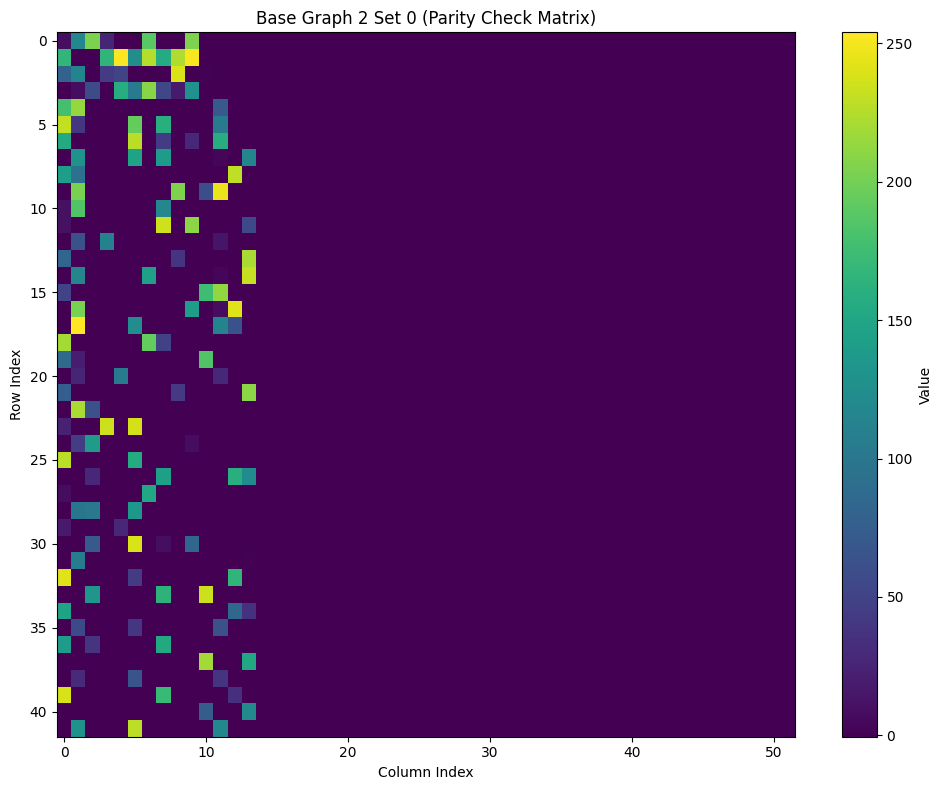

In [ ]:
import os
import networkx as nx

# GPU settings
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

# get the base graph and generator matrix
import matplotlib.pyplot as plt

# Create directories for visualizations if they don't exist
os.makedirs("./Visualizations", exist_ok=True)

# Load matrices
code_PCM0 = np.loadtxt("./BaseGraph/BaseGraph2_Set0.txt", int, delimiter='\t')
code_PCM1 = np.loadtxt("./BaseGraph/BaseGraph2_Set1.txt", int, delimiter='\t')
code_PCM2 = np.loadtxt("./BaseGraph/BaseGraph2_Set2.txt", int, delimiter='\t')
code_GM_16 = np.loadtxt("./BaseGraph_GM/LDPC_GM_BG2_16.txt", int, delimiter=',')
code_GM_3 = np.loadtxt("./BaseGraph_GM/LDPC_GM_BG2_3.txt", int, delimiter=',')
code_GM_10 = np.loadtxt("./BaseGraph_GM/LDPC_GM_BG2_10.txt", int, delimiter=',')
code_GM_6 = np.loadtxt("./BaseGraph_GM/LDPC_GM_BG2_6.txt", int, delimiter=',')
code_PCM = code_PCM0.copy()

# Function to visualize a matrix as a heatmap
def visualize_matrix(matrix, title, filename):
    plt.figure(figsize=(10, 8))
    # Replace -1 values with a different color for better visualization
    display_matrix = matrix.copy()
    if -1 in display_matrix:
        cmap = plt.cm.viridis
        display_matrix[display_matrix == -1] = -0.5
        vmin, vmax = -0.5, max(1, display_matrix.max())
    else:
        cmap = plt.cm.binary
        vmin, vmax = 0, 1
        
    plt.imshow(display_matrix, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.tight_layout()
    plt.savefig(f"./Visualizations/{filename}.png", dpi=300)
    plt.close()

# Visualize base graphs (parity check matrices)
visualize_matrix(code_PCM0, "Base Graph 2 Set 0 (Parity Check Matrix)", "base_graph_0")
visualize_matrix(code_PCM1, "Base Graph 2 Set 1 (Parity Check Matrix)", "base_graph_1")
visualize_matrix(code_PCM2, "Base Graph 2 Set 2 (Parity Check Matrix)", "base_graph_2")

# Visualize generator matrices
visualize_matrix(code_GM_16, f"Generator Matrix (Z=16, {code_GM_16.shape})", "gen_matrix_16")
visualize_matrix(code_GM_3, f"Generator Matrix (Z=3, {code_GM_3.shape})", "gen_matrix_3")
visualize_matrix(code_GM_10, f"Generator Matrix (Z=10, {code_GM_10.shape})", "gen_matrix_10")
visualize_matrix(code_GM_6, f"Generator Matrix (Z=6, {code_GM_6.shape})", "gen_matrix_6")

# Plot connectivity graph for one of the PCMs to visualize the LDPC structure
def plot_tanner_graph(H, max_nodes=50, title="Tanner Graph Representation"):
    try:
        
        # Create a bipartite graph
        G = nx.Graph()
        
        # Limit the size for visualization purposes
        m, n = min(H.shape[0], max_nodes), min(H.shape[1], max_nodes)
        
        # Add variable nodes (columns)
        var_nodes = [f"v{i}" for i in range(n)]
        # Add check nodes (rows)
        check_nodes = [f"c{i}" for i in range(m)]
        
        # Add all nodes to the graph
        G.add_nodes_from(var_nodes, bipartite=0)
        G.add_nodes_from(check_nodes, bipartite=1)
        
        # Add edges where H[i,j] != 0 and H[i,j] != -1
        for i in range(m):
            for j in range(n):
                if H[i,j] > 0:  # Only connect if there's a positive value (connection)
                    G.add_edge(f"c{i}", f"v{j}")
                    
        # Create a layout for visualization
        pos = nx.spring_layout(G)
        
        plt.figure(figsize=(12, 10))
        # Draw variable nodes
        nx.draw_networkx_nodes(G, pos, nodelist=var_nodes, node_color='skyblue', 
                              node_size=300, label="Variable Nodes")
        # Draw check nodes
        nx.draw_networkx_nodes(G, pos, nodelist=check_nodes, node_color='lightgreen', 
                              node_size=300, label="Check Nodes")
        # Draw edges
        nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=8)
        
        plt.title(title)
        plt.legend()
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(f"./Visualizations/tanner_graph.png", dpi=300)
        plt.close()
    except ImportError:
        print("NetworkX library not found. Skipping Tanner graph visualization.")

# Try to plot a Tanner graph representation for code_PCM0
plot_tanner_graph(code_PCM0, title="LDPC Tanner Graph (Base Graph 2 Set 0)")

# Function to visualize training convergence
def setup_convergence_plot():
    plt.figure(figsize=(12, 8))
    plt.title("Neural LDPC Decoder Training Progress")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

`code_PCM`: loaded from BaseGraph/BaseGraph2_Set0.txt through 

ShapeLayer: why make code_PCM to have 0 or 1 value after loaded form text file and copy immediately?

GitHub.copilot-chat.github.copilot.editor: # LDPC Code Matrix Processing

This code is processing Parity Check Matrices (PCMs) for Low-Density Parity-Check (LDPC) codes. Here's why the code is converting values to 0 or 1:

The code loads several PCMs from text files, then copies `code_PCM0` to `code_PCM`. After loading these matrices, the code processes `code_PCM` by converting:
- Values of `-1` to `0`
- All other values to `1`

This transformation is performed because:

1. **Binary representation**: LDPC codes typically work with binary matrices. However, some representations use `-1` to indicate "no connection" between nodes in the Tanner graph.

2. **Standard format**: Converting to 0/1 values puts the matrix in a standard binary format that's needed for subsequent operations in LDPC decoding algorithms.

3. **Numerical operations**: Having consistent 0/1 values simplifies matrix operations like multiplication that might be used later in the code.

The timing is noteworthy - the code first loads all matrices, creates a copy of `code_PCM0`, and then only processes that copy. The original matrices in `Ldpc_PCM` and `Ldpc_GM` arrays remain unchanged, suggesting these unchanged matrices may be used separately in their original form elsewhere in the program.

ShapeLayer: then this code represents hypothetical situation that converting value to binary when input numerical matrix?

GitHub Copilot: Yes, this code represents converting a numerical matrix into a binary representation, but it's not just a hypothetical situation. Let me explain why:

## Matrix Conversion Process

```python
# Original matrix loaded from file contains -1 and positive integers
code_PCM = code_PCM0.copy()

# Converting to binary (0/1) representation
for i in range(0, code_PCM.shape[0]):
    for j in range(0, code_PCM.shape[1]):
        if (code_PCM[i, j] == -1):
            code_PCM[i, j] = 0  # No connection
        else:
            code_PCM[i, j] = 1  # Connection exists
```

This conversion serves two critical purposes in LDPC decoding:

1. **Tanner Graph Structure**
   - `-1` → `0`: No edge between nodes
   - Any positive value → `1`: Edge exists between nodes
   - This binary form directly represents the connectivity in the Tanner graph

2. **Neural Network Processing**
   - The binary matrix is used to initialize connection matrices:
     - `W_odd2even`: Variable node connections
     - `W_even2odd`: Check node connections 
     - `W_output`: Output layer connections

The original positive values (before conversion) are preserved in `Ldpc_PCM` for cyclic shift operations using the `Z` lifting factors, while the binary version is used for network structure setup.

This is not hypothetical - it's a necessary transformation for implementing a neural LDPC decoder.

ShapeLayer: then there isn't hypothentical situation, why positive value are different each?

# Understanding Positive Values in PCM

The positive values in the original parity check matrix (PCM) are not hypothetical - they have specific meanings in protograph-based LDPC codes:

## PCM Value Meanings

1. **Original Values**
   - `-1`: No connection between nodes
   - Positive integers (e.g., 1, 2, 3...): Cyclic shift values for protograph lifting

2. **Binary Conversion**
```python
# All positive values become 1 for connectivity matrix
if (code_PCM[i, j] == -1):
    code_PCM[i, j] = 0  # No connection
else:
    code_PCM[i, j] = 1  # Connection exists
```

3. **Why Different Positive Values?**
   - The original positive values indicate **cyclic shift amounts** used in `Lift_Matrix1` and `Lift_Matrix2`
   - Example from the code:
```python
# Using original values for lifting
if (code_PCM1[i, j] != -1):
    Lift_num = code_PCM1[i, j] % Z_array[t]  # Get cyclic shift amount
    for h in range(0, Z_array[t], 1):
        Lift_M1[k * Z_array[t] + h, k * Z_array[t] + (h + Lift_num) % Z_array[t]] = 1
```

So while the connectivity matrix uses binary values (0/1), the original different positive values are preserved and used for determining cyclic shifts in the lifted (expanded) LDPC code structure.

ShapeLayer: then origin code_pcm is "cyclic shift values" and overrided code_pcm is boolean that represents i, j is connected?



Copilot:
# Understanding the Two Uses of PCM Matrix

Yes, exactly! The PCM (Parity Check Matrix) serves two different purposes:

1. **Original PCM** (before conversion):
```python
# Original PCM contains cyclic shift values
code_PCM0 = np.loadtxt("./BaseGraph/BaseGraph2_Set0.txt", int, delimiter='\t')
# Values:
# -1: No connection
# Positive integers: Cyclic shift amounts for each connection
```

2. **Converted PCM** (after binary conversion):
```python
# Convert to binary connectivity matrix
code_PCM = code_PCM0.copy()
for i in range(0, code_PCM.shape[0]):
    for j in range(0, code_PCM.shape[1]):
        if (code_PCM[i, j] == -1):
            code_PCM[i, j] = 0  # No connection
        else:
            code_PCM[i, j] = 1  # Connection exists
```

## Key Differences
- **Original PCM** (`Ldpc_PCM`): Used for cyclic shifts in protograph lifting
  - Preserves shift values for `Lift_Matrix1` and `Lift_Matrix2` construction
  - Example: `Lift_num = code_PCM1[i, j] % Z_array[t]`

- **Converted PCM** (`code_PCM`): Used for neural network connectivity
  - Binary representation (0/1) showing node connections
  - Used to build connection matrices like `W_odd2even`, `W_even2odd`, `W_output`

In [ ]:
N = 52
m = 42
code_n = N
code_k = N - m
for i in range(0, code_PCM.shape[0]):
    for j in range(0, code_PCM.shape[1]):
        if (code_PCM[i, j] == -1):
            code_PCM[i, j] = 0
        else:
            code_PCM[i, j] = 1

In [ ]:
code_PCM

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 1]])

ShapeLayer: "iterations the network" in the statement "The code first defines iters_max = 25, which specifies the maximum number of decoding iterations the network will perform. This is a typical value for LDPC decoding algorithms." menas neural network?

---

Copilot:

No, in this context "iterations" refers to the message-passing decoding iterations of the LDPC decoder, not neural network training iterations. Let me explain:

1. LDPC Decoding Iterations (iters_max = 25):
    - This represents how many times messages are passed between variable nodes and check nodes in the Tanner graph
    - In traditional LDPC decoding, messages are iteratively exchanged until a valid codeword is found or max iterations reached
    - 25 iterations is a typical number for LDPC decoders to achieve good error correction
2. Neural Network Training (different concept):
    - The actual neural network training is controlled by num_of_batch = 50000
    - Training happens in the last section with the loop for iter in range(0, iters_max, 1):
    - Each decoder iteration is implemented as a neural network layer, but iters_max controls decoder depth, not training epochs

    
So while this is a neural implementation of an LDPC decoder, the iters_max parameter represents the number of decoder iterations, which is being modeled using 25 sequential neural network layers.

In [ ]:
# network hyper-parameters
iters_max = 25     # number of iterations
sum_edge_c = np.sum(code_PCM, axis=1)
sum_edge_v = np.sum(code_PCM, axis=0)
sum_edge = np.sum(sum_edge_v)
neurons_per_even_layer = neurons_per_odd_layer = np.sum(sum_edge_v)
input_output_layer_size = N

ShapeLayer: what is the AWGN

GitHub Copilot: AWGN stands for Additive White Gaussian Noise, which is a basic noise model used in information theory to mimic the effects of random processes that occur in nature. In this code, AWGN is used to simulate channel noise in the communication system. Let's break down how it's implemented:

1. First, the code calculates noise parameters:
```python
code_rate = 1.0 * (N - m) / (N-2)
SNR_Matrix = np.array([[9.0,6.05,4.1,...],  # Signal-to-Noise Ratio (SNR) values
                       [9.1,6.2,4.6,...],
                       [9,6.05,4.1,...],
                       [9.0,6.1,4.25,...]])
SNR_lin = 10.0 ** (SNR_Matrix / 10.0)  # Convert SNR from dB to linear scale
SNR_sigma = np.sqrt(1.0 / (2.0 * SNR_lin * code_rate))  # Calculate noise standard deviation
```

2. The AWGN is applied in the `create_mix_epoch` function:
```python
# Add AWGN to the signal
X_p_i = noiseRandom.normal(0.0, 1.0, Y_i.shape) * sf_i + (-1) ** (1 - Y_i)
# where:
# - noiseRandom.normal(0.0, 1.0, ...) generates Gaussian noise with mean 0 and variance 1
# - sf_i is the scaling factor (noise standard deviation)
# - (-1) ** (1 - Y_i) converts binary 0/1 to BPSK symbols (-1/+1)
```

Key characteristics of AWGN:
- Additive: The noise is added to the signal
- White: The noise has uniform power across the frequency spectrum
- Gaussian: The noise follows a normal (Gaussian) distribution
- The noise samples are statistically independent

This noise model is commonly used in communication systems to test the robustness of error correction codes like LDPC codes.

ShapeLayer: what is the `SNR_Matrix`? why this literal value are setted like that

GitHub Copilot: # SNR_Matrix Explained: Curriculum Learning for Neural LDPC Decoding

The `SNR_Matrix` is a 4×25 array of Signal-to-Noise Ratio (SNR) values in decibels (dB) that serves as a curriculum learning schedule for training the neural LDPC decoder across different configurations.

## Structure and Function

```python
SNR_Matrix = np.array([
    [9.0, 6.05, 4.1, ..., 0.7],  # For Z=16 configuration
    [9.1, 6.2, 4.6, ..., 2.25],  # For Z=3 configuration
    [9.0, 6.05, 4.1, ..., 1.0],  # For Z=10 configuration
    [9.0, 6.1, 4.25, ..., 1.4]   # For Z=6 configuration
])
```

- **Rows (4)**: Each row corresponds to one of the four LDPC code configurations (Z=16, Z=3, Z=10, Z=6)
- **Columns (25)**: Each column corresponds to one of the 25 decoder iterations (`iters_max=25`)
- **Values**: Signal-to-Noise Ratio in dB, used to compute `SNR_sigma` (noise standard deviation)

## Why These Specific Values?

These values implement a curriculum learning strategy:

1. **Gradually Decreasing SNR Values**: 
   - Start with high SNR (around 9dB) → easier decoding tasks with minimal noise
   - End with low SNR (0.7-2.25dB) → challenging decoding tasks with significant noise
   
2. **Code-Specific Considerations**:
   - Different rows have different profiles because each LDPC configuration has unique performance characteristics
   - Z=3 configuration (row 2) has higher SNR values overall, suggesting it requires cleaner signals
   - Z=16 configuration (row 1) reaches the lowest SNR (0.7dB), suggesting better noise tolerance

3. **Plateauing Values**:
   - The values at the end of each row stabilize (e.g., multiple 0.7s in first row)
   - This represents reaching a minimum effective SNR for each configuration

During training, the appropriate noise level is selected based on the current iteration and LDPC configuration:
```python
SNR_set = np.array([SNR_sigma[Z_type, iter]])
```

This approach allows the neural network to learn decoding strategies gradually, starting with simpler scenarios before tackling more challenging ones.

In [ ]:
# init the AWGN #
code_rate = 1.0 * (N - m) / (N-2)
# train SNR
SNR_Matrix = np.array([[9.0,6.05,4.1,2.95,2.25,1.8,1.55,1.3,1.15,1.05,0.94,0.85,0.83,0.81,0.8,0.8,0.8,0.75,0.75,0.7,0.7,0.7,0.7,0.7,0.7],
                       [9.1,6.2,4.6,3.7,3.2,3.0,2.8,2.7,2.6,2.55,2.5,2.45,2.4,2.4,2.4,2.35,2.35,2.3,2.3,2.3,2.25,2.25,2.25,2.25,2.25],
                       [9,6.05,4.1,3,2.4,2,1.7,1.5,1.4,1.4,1.3,1.3,1.2,1.2,1.2,1.2,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1,1],
                       [9.0,6.1,4.25,3.2,2.6,2.25,2,1.9,1.8,1.7,1.7,1.65,1.6,1.6,1.55,1.55,1.5,1.5,1.5,1.45,1.45,1.4,1.4,1.4,1.4]])
    # Linear SNR
SNR_lin = 10.0 ** (SNR_Matrix / 10.0)
    # Noise Standard Deviation
SNR_sigma = np.sqrt(1.0 / (2.0 * SNR_lin * code_rate))
# ramdom seed
word_seed = 2042
noise_seed = 1074
wordRandom = np.random.RandomState(word_seed)  # word seed
noiseRandom = np.random.RandomState(noise_seed)  # noise seed

In [ ]:
# train settings
learning_rate = 0.001
train_on_zero_word = True
numOfWordSim_train = 50
batch_size = numOfWordSim_train
num_of_batch = 50000

ShapeLayer: what is the `create_mix_epoch`?

GitHub Copilot: # `create_mix_epoch` Function Explanation

The `create_mix_epoch` function is a data generation utility that creates training batches for the neural LDPC decoder. It simulates the entire communication process from encoding to channel transmission.

## Function Purpose

```python
def create_mix_epoch(scaling_factor, wordRandom, noiseRandom, numOfWordSim, 
                     code_n, code_k, Z, code_GM, is_zeros_word):
```

This function generates pairs of:
- **Input data (X)**: Noisy channel observations (as log-likelihood ratios)
- **Target labels (Y)**: Original codeword bits

## Step-by-Step Process

1. **Information Bit Generation**:
   ```python
   if is_zeros_word:
       infoWord_i = 0 * wordRandom.randint(0, 2, size=(numOfWordSim, code_k * Z))
   else:
       infoWord_i = wordRandom.randint(0, 2, size=(numOfWordSim, code_k * Z))
   ```
   - Either generates random information bits or all-zeros words
   - The `train_on_zero_word = True` parameter is set globally to use all-zeros

2. **LDPC Encoding**:
   ```python
   Y_i = np.dot(infoWord_i, code_GM) % 2
   ```
   - Multiplies information bits with generator matrix
   - Modulo-2 operation produces binary codewords

3. **Channel Transmission Simulation**:
   ```python
   X_p_i = noiseRandom.normal(0.0, 1.0, Y_i.shape) * sf_i + (-1) ** (1 - Y_i)
   ```
   - Converts bits to BPSK symbols (0→-1, 1→1)
   - Adds AWGN (Additive White Gaussian Noise) scaled by `sf_i`
   - `sf_i` is derived from the SNR value for the current iteration

4. **LLR Calculation**:
   ```python
   x_llr_i = 2 * X_p_i / ((sf_i) ** 2)
   ```
   - Converts received symbols to Log-Likelihood Ratios
   - These are soft-decision values used by the decoder

5. **Data Organization**:
   ```python
   X = np.vstack((X, x_llr_i))
   Y = np.vstack((Y, Y_i))
   X = X[1:]
   Y = Y[1:]
   X = np.reshape(X, [batch_size, code_n, Z])
   ```
   - Accumulates data for the full batch
   - Reshapes X to match the network's expected input format

## Usage in Training

This function is called during the training loop for each of the four LDPC configurations:

```python
SNR_set = np.array([SNR_sigma[Z_type, iter]])
training_received_data, training_coded_bits = create_mix_epoch(
    SNR_set, wordRandom, noiseRandom, numOfWordSim_train,
    code_n, code_k, Z, Ldpc_GM[Z_type], train_on_zero_word)
```

The function implements a curriculum learning strategy where noise levels gradually increase (SNR decreases) as training progresses through the iterations, making the learning task progressively more challenging.

ShapeLayer: what does that mean "# pay attention to this 1->1 o->-1"

GitHub Copilot: # BPSK Modulation Explained: `1->1 0->-1`

This comment refers to the Binary Phase Shift Keying (BPSK) modulation happening in this line:

```python
X_p_i = noiseRandom.normal(0.0, 1.0, Y_i.shape) * sf_i + (-1) ** (1 - Y_i)
```

## What It Means

The comment `# pay attention to this 1->1 0->-1` is explaining the mathematical mapping occurring with the expression `(-1) ** (1 - Y_i)`:

- When `Y_i` = 1 (binary bit '1'):
  - `1 - Y_i` = 0
  - `(-1) ** 0` = 1
  - So binary '1' → transmitted symbol '+1'

- When `Y_i` = 0 (binary bit '0'):
  - `1 - Y_i` = 1
  - `(-1) ** 1` = -1
  - So binary '0' → transmitted symbol '-1'

## Why It's Important

This transformation is crucial because:

1. **BPSK Modulation**: This is the standard method for converting binary data to antipodal signals for transmission

2. **Signal Energy**: The ±1 representation ensures equal energy per bit, which is optimal for noise resistance

3. **AWGN Channel Simulation**: The full line simulates transmission over a noisy channel:
   ```
   BPSK symbol + Gaussian noise = Received symbol
      ±1      + random noise   = X_p_i
   ```

4. **LLR Calculation**: This representation makes it easier to calculate Log-Likelihood Ratios (LLRs) in the following line, which are the soft inputs required by the neural LDPC decoder

In summary, this comment highlights a key part of the digital communication system being simulated - the conversion from binary data to BPSK symbols before transmission through the noisy channel.

## 모델 학습 데이터 생성 <sup><code>create_mix_epoch</code></sup>

$$
\begin{align*}

\text{info}_i &= \begin{cases}
  \text{random}(\text{WordSim}, code_k \cdot Z) & \text{if } \text{is\_zeros\_word} = \text{False} \\
  0_{(\text{WordSim}, code_k \cdot Z)} & \text{if } \text{is\_zeros\_word} = \text{True}
\end{cases} \\[1em]

Y_i &= \text{info}_i \cdot G \\[0.5em]
X_{p_i} &= \text{Random} \cdot \text{Scaler}_i + (-1)^{1-Y_i} \\[0.5em]
X_{\text{llr}_i} &= 2X_{p_i}/\text{Scaler}_i^2 \\[0.5em]

X &= \begin{bmatrix}
X_{\text{llr}_1} \\
X_{\text{llr}_2} \\
\vdots \\
X_{\text{llr}_n}
\end{bmatrix} \\[0.5em]

Y &= \begin{bmatrix}
  Y_1 \\
  Y_2 \\
  \vdots \\
  Y_n
\end{bmatrix} \\[0.5em]

\end{align*}
$$

$\therefore$ $X$ = 노이즈를 거친 코드워드의 LLR; $y$ = 원래 코드워드

In [ ]:
# Used at Training

# In the context of this neural LDPC decoding code, the term "mix" 
# in the create_mix_epoch function refers to the mixing of multiple 
# elements to create comprehensive training batches. The function 
# creates mixed training data in several ways:

#get train samples
def create_mix_epoch(scaling_factor, wordRandom, noiseRandom, numOfWordSim, code_n, code_k, Z, code_GM, is_zeros_word):
    X = np.zeros([1, code_n * Z], dtype=np.float32)
    Y = np.zeros([1, code_n * Z], dtype=np.int64)

    # build set for epoch
    for sf_i in scaling_factor:
        if is_zeros_word:
            infoWord_i = 0 * wordRandom.randint(0, 2, size=(numOfWordSim, code_k * Z))
        else:
            infoWord_i = wordRandom.randint(0, 2, size=(numOfWordSim, code_k * Z))

        Y_i = np.dot(infoWord_i, code_GM) % 2
        # Generate data with specific noise level
        X_p_i = noiseRandom.normal(0.0, 1.0, Y_i.shape) * sf_i + (-1) ** (1 - Y_i)  # pay attention to this 1->1 0->-1
        x_llr_i = 2 * X_p_i / ((sf_i) ** 2)  # defined as p1/p0
        X = np.vstack((X, x_llr_i))
        Y = np.vstack((Y, Y_i))
    X = X[1:]
    Y = Y[1:]
    X = np.reshape(X, [batch_size, code_n, Z])
    return X, Y

In [ ]:
# calculate ber and fer
def calc_ber_fer(snr_db, Y_test_pred, Y_test, numOfWordSim):
    ber_test = np.zeros(snr_db.shape[0])
    fer_test = np.zeros(snr_db.shape[0])
    for i in range(0, snr_db.shape[0]):
        Y_test_pred_i = Y_test_pred[i * numOfWordSim:(i + 1) * numOfWordSim, :]
        Y_test_i = Y_test[i * numOfWordSim:(i + 1) * numOfWordSim, :]
        ber_test[i] = np.abs(((Y_test_pred_i > 0) - Y_test_i)).sum() / (Y_test_i.shape[0] * Y_test_i.shape[1])
        fer_test[i] = (np.abs(((Y_test_pred_i > 0) - Y_test_i)).sum(axis=1) > 0).sum() * 1.0 / Y_test_i.shape[0]
    return ber_test, fer_test

In [ ]:
############################     init the connecting matrix between network layers   #################################
Lift_Matrix1 = []
Lift_Matrix2 = []
W_odd2even = np.zeros((sum_edge, sum_edge), dtype=np.float32)
W_skipconn2even = np.zeros((N, sum_edge), dtype=np.float32)
W_even2odd = np.zeros((sum_edge, sum_edge), dtype=np.float32)
W_output = np.zeros((sum_edge, N), dtype=np.float32)


In [ ]:
# init lifting matrix for cyclic shift
for t in range(0, 4, 1):
    Lift_M1 = np.zeros((neurons_per_odd_layer * Z_array[t], neurons_per_odd_layer * Z_array[t]), np.float32)
    Lift_M2 = np.zeros((neurons_per_odd_layer * Z_array[t], neurons_per_odd_layer * Z_array[t]), np.float32)
    code_PCM1 = Ldpc_PCM[t]
    k = 0
    for j in range(0, code_PCM1.shape[1]):
        for i in range(0, code_PCM1.shape[0]):
            if (code_PCM1[i, j] != -1):
                Lift_num = code_PCM1[i, j] % Z_array[t]
                for h in range(0, Z_array[t], 1):
                    Lift_M1[k * Z_array[t] + h, k * Z_array[t] + (h + Lift_num) % Z_array[t]] = 1
                k = k + 1
    k = 0
    for i in range(0, code_PCM1.shape[0]):
        for j in range(0, code_PCM1.shape[1]):
            if (code_PCM1[i, j] != -1):
                Lift_num = code_PCM1[i, j] % Z_array[t]
                for h in range(0, Z_array[t], 1):
                    Lift_M2[k * Z_array[t] + h, k * Z_array[t] + (h + Lift_num) % Z_array[t]] = 1
                k = k + 1
    Lift_Matrix1.append(Lift_M1)
    Lift_Matrix2.append(Lift_M2)


In [ ]:
# init W_odd2even  variable node updating
k = 0
vec_tmp = np.zeros((sum_edge), dtype=np.float32)  # even layer index read with column
for j in range(0, code_PCM.shape[1], 1):  # run over the columns
    for i in range(0, code_PCM.shape[0], 1):  # break after the first one
        if (code_PCM[i, j] == 1):  # finding the first one is ok
            num_of_conn = int(np.sum(code_PCM[:, j]))  # get the number of connection of the variable node
            idx = np.argwhere(code_PCM[:, j] == 1)  # get the indexes
            for l in range(0, num_of_conn, 1):  # adding num_of_conn columns to W
                vec_tmp = np.zeros((sum_edge), dtype=np.float32)
                for r in range(0, code_PCM.shape[0], 1):  # adding one to the right place
                    if (code_PCM[r, j] == 1 and idx[l][0] != r):
                        idx_row = np.cumsum(code_PCM[r, 0:j + 1])[-1] - 1
                        odd_layer_node_count = 0
                        if r > 0:
                            odd_layer_node_count = np.cumsum(sum_edge_c[0:r])[-1]
                        vec_tmp[idx_row + odd_layer_node_count] = 1  # offset index adding
                W_odd2even[:, k] = vec_tmp.transpose()
                k += 1
            break


In [ ]:
# init W_even2odd  parity check node updating
k = 0
for j in range(0, code_PCM.shape[1], 1):
    for i in range(0, code_PCM.shape[0], 1):
        if (code_PCM[i, j] == 1):
            idx_row = np.cumsum(code_PCM[i, 0:j + 1])[-1] - 1
            idx_col = np.cumsum(code_PCM[0: i + 1, j])[-1] - 1
            odd_layer_node_count_1 = 0
            odd_layer_node_count_2 = np.cumsum(sum_edge_c[0:i + 1])[-1]
            if i > 0:
                odd_layer_node_count_1 = np.cumsum(sum_edge_c[0:i])[-1]
            W_even2odd[k, odd_layer_node_count_1:odd_layer_node_count_2] = 1.0
            W_even2odd[k, odd_layer_node_count_1 + idx_row] = 0.0
            k += 1  # k is counted in column direction


In [ ]:
# init W_output odd to output
k = 0
for j in range(0, code_PCM.shape[1], 1):
    for i in range(0, code_PCM.shape[0], 1):
        if (code_PCM[i, j] == 1):
            idx_row = np.cumsum(code_PCM[i, 0:j + 1])[-1] - 1
            idx_col = np.cumsum(code_PCM[0: i + 1, j])[-1] - 1
            odd_layer_node_count = 0
            if i > 0:
                odd_layer_node_count = np.cumsum(sum_edge_c[0:i])[-1]
            W_output[odd_layer_node_count + idx_row, k] = 1.0
    k += 1


In [ ]:
# init W_skipconn2even  channel input
k = 0
for j in range(0, code_PCM.shape[1], 1):
    for i in range(0, code_PCM.shape[0], 1):
        if (code_PCM[i, j] == 1):
            W_skipconn2even[j, k] = 1.0
            k += 1



In [ ]:
##############################  bulid four neural networks(Z = 16,3, 10, 6) ############################
net_dict = {}
# init the learnable network parameters
Weights_Var = 0.5 * np.ones(sum_edge, dtype=np.float32)
Biases_Var = np.zeros(sum_edge, dtype=np.float32)
for i in range(0, iters_max, 1):
    net_dict["Weights_Var{0}".format(i)] = tf.Variable(Weights_Var.copy(), name="Weights_Var".format(i))
    net_dict["Biases_Var{0}".format(i)] = tf.Variable(Biases_Var.copy(), name="Biases_Var".format(i))


In [ ]:
# the decoding neural network of Z=16
Z = 16
xa = tf.placeholder(tf.float32, shape=[batch_size, N, Z], name='xa')
ya = tf.placeholder(tf.float32, shape=[batch_size, N * Z], name='ya')
xa_input = tf.transpose(xa, [0, 2, 1])
net_dict["LLRa{0}".format(0)] = tf.zeros((batch_size, Z, sum_edge), dtype=tf.float32)
for i in range(0, iters_max, 1):
    #variable node update
    x0 = tf.matmul(xa_input, W_skipconn2even)
    x1 = tf.matmul(net_dict["LLRa{0}".format(i)], W_odd2even)
    x2 = tf.add(x0, x1)
    x2 = tf.transpose(x2, [0, 2, 1])
    x2 = tf.reshape(x2, [batch_size, neurons_per_odd_layer * Z])
    x2 = tf.matmul(x2, Lift_Matrix1[0].transpose())
    x2 = tf.reshape(x2, [batch_size, neurons_per_odd_layer, Z])
    x2 = tf.transpose(x2, [0, 2, 1])
    x_tile = tf.tile(x2, multiples=[1, 1, neurons_per_odd_layer])
    W_input_reshape = tf.reshape(W_even2odd.transpose(), [-1])
    #check node update
    x_tile_mul = tf.multiply(x_tile, W_input_reshape)
    x2_1 = tf.reshape(x_tile_mul, [batch_size, Z, neurons_per_odd_layer, neurons_per_odd_layer])
    x2_abs = tf.add(tf.abs(x2_1), 10000 * (1 - tf.to_float(tf.abs(x2_1) > 0)))
    x3 = tf.reduce_min(x2_abs, axis=3)
    x2_2 = -x2_1
    x4 = tf.add(tf.zeros((batch_size, Z, neurons_per_odd_layer, neurons_per_odd_layer)), 1 - 2 * tf.to_float(x2_2 < 0))
    x4_prod = -tf.reduce_prod(x4, axis=3)
    x_output_0 = tf.multiply(x3, tf.sign(x4_prod))
    x_output_0 = tf.transpose(x_output_0, [0, 2, 1])
    x_output_0 = tf.reshape(x_output_0, [batch_size, Z * neurons_per_odd_layer])
    x_output_0 = tf.matmul(x_output_0, Lift_Matrix2[0])
    x_output_0 = tf.reshape(x_output_0, [batch_size, neurons_per_odd_layer, Z])
    x_output_0 = tf.transpose(x_output_0, [0, 2, 1])
    # add learnable parameters
    x_output_1 = tf.add(tf.multiply(tf.abs(x_output_0),net_dict["Weights_Var{0}".format(i)]), net_dict["Biases_Var{0}".format(i)])
    x_output_1 = tf.multiply(x_output_1, tf.to_float(x_output_1 > 0))
    net_dict["LLRa{0}".format(i+1)] = tf.multiply(x_output_1, tf.sign(x_output_0)) # update the LLR
    # output
    y_output_2 = tf.matmul(net_dict["LLRa{0}".format(i+1)], W_output)
    y_output_3 = tf.transpose(y_output_2, [0, 2, 1])
    y_output_4 = tf.add(xa, y_output_3)
    net_dict["ya_output{0}".format(i)] = tf.reshape(y_output_4, [batch_size, N * Z], name='ya_output'.format(i))
    # calculate loss
    net_dict["lossa{0}".format(i)] = 1.0 * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=ya,
                                                            logits=net_dict["ya_output{0}".format(i)]), name='lossa'.format(i))
    # AdamOptimizer
    net_dict["train_stepa{0}".format(i)] = tf.train.AdamOptimizer(learning_rate=
                                                                learning_rate).minimize(net_dict["lossa{0}".format(i)],
                                var_list = [net_dict["Weights_Var{0}".format(i)], net_dict["Biases_Var{0}".format(i)]])


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
# the decoding neural network of Z=3
Z = 3
xb = tf.placeholder(tf.float32, shape=[batch_size, N, Z], name='xb')
yb = tf.placeholder(tf.float32, shape=[batch_size, N * Z], name='yb')
xb_input = tf.transpose(xb, [0, 2, 1])
net_dict["LLRb{0}".format(0)] = tf.zeros((batch_size, Z, sum_edge), dtype=tf.float32)
for i in range(0, iters_max, 1):
    #variable node update
    x0 = tf.matmul(xb_input, W_skipconn2even)
    x1 = tf.matmul(net_dict["LLRb{0}".format(i)], W_odd2even)
    x2 = tf.add(x0, x1)
    x2 = tf.transpose(x2, [0, 2, 1])
    x2 = tf.reshape(x2, [batch_size, neurons_per_odd_layer * Z])
    x2 = tf.matmul(x2, Lift_Matrix1[1].transpose())
    x2 = tf.reshape(x2, [batch_size, neurons_per_odd_layer, Z])
    x2 = tf.transpose(x2, [0, 2, 1])
    x_tile = tf.tile(x2, multiples=[1, 1, neurons_per_odd_layer])
    W_input_reshape = tf.reshape(W_even2odd.transpose(), [-1])
    # check node update
    x_tile_mul = tf.multiply(x_tile, W_input_reshape)
    x2_1 = tf.reshape(x_tile_mul, [batch_size, Z, neurons_per_odd_layer, neurons_per_odd_layer])
    x2_abs = tf.add(tf.abs(x2_1), 100 * (1 - tf.to_float(tf.abs(x2_1) > 0)))
    x3 = tf.reduce_min(x2_abs, axis=3)
    x2_2 = -x2_1
    x4 = tf.add(tf.zeros((batch_size, Z, neurons_per_odd_layer, neurons_per_odd_layer)), 1 - 2 * tf.to_float(x2_2 < 0))
    x4_prod = -tf.reduce_prod(x4, axis=3)
    x_output_0 = tf.multiply(x3, tf.sign(x4_prod))
    x_output_0 = tf.transpose(x_output_0, [0, 2, 1])
    x_output_0 = tf.reshape(x_output_0, [batch_size, Z * neurons_per_odd_layer])
    x_output_0 = tf.matmul(x_output_0, Lift_Matrix2[1])
    x_output_0 = tf.reshape(x_output_0, [batch_size, neurons_per_odd_layer, Z])
    x_output_0 = tf.transpose(x_output_0, [0, 2, 1])
    # add learnable parameters
    x_output_1 = tf.add(tf.multiply(tf.abs(x_output_0), net_dict["Weights_Var{0}".format(i)]), net_dict["Biases_Var{0}".format(i)])
    x_output_1 = tf.multiply(x_output_1, tf.to_float(x_output_1 > 0))
    net_dict["LLRb{0}".format(i+1)] = tf.multiply(x_output_1, tf.sign(x_output_0))
    # output
    y_output_2 = tf.matmul(net_dict["LLRb{0}".format(i+1)], W_output)
    y_output_3 = tf.transpose(y_output_2, [0, 2, 1])
    y_output_4 = tf.add(xb, y_output_3)
    net_dict["yb_output{0}".format(i)] = tf.reshape(y_output_4, [batch_size, N * Z], name='yb_output'.format(i))
    # calculate loss
    net_dict["lossb{0}".format(i)] = 1.0 * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=yb,
                                                            logits=net_dict["yb_output{0}".format(i)]), name='lossb'.format(i))
    # AdamOptimizer
    net_dict["train_stepb{0}".format(i)] = tf.train.AdamOptimizer(learning_rate=
                                                                learning_rate).minimize(net_dict["lossb{0}".format(i)],
                                var_list = [net_dict["Weights_Var{0}".format(i)], net_dict["Biases_Var{0}".format(i)]])


In [ ]:
# the decoding neural network of Z=10
Z = 10
xc = tf.placeholder(tf.float32, shape=[batch_size, N, Z], name='xc')
yc = tf.placeholder(tf.float32, shape=[batch_size, N * Z], name='yc')
xc_input = tf.transpose(xc, [0, 2, 1])
net_dict["LLRc{0}".format(0)] = tf.zeros((batch_size, Z, sum_edge), dtype=tf.float32)
for i in range(0, iters_max, 1):
    # variable node update
    x0 = tf.matmul(xc_input, W_skipconn2even)
    x1 = tf.matmul(net_dict["LLRc{0}".format(i)], W_odd2even)
    x2 = tf.add(x0, x1)
    x2 = tf.transpose(x2, [0, 2, 1])
    x2 = tf.reshape(x2, [batch_size, neurons_per_odd_layer * Z])
    x2 = tf.matmul(x2, Lift_Matrix1[2].transpose())
    x2 = tf.reshape(x2, [batch_size, neurons_per_odd_layer, Z])
    x2 = tf.transpose(x2, [0, 2, 1])
    x_tile = tf.tile(x2, multiples=[1, 1, neurons_per_odd_layer])
    W_input_reshape = tf.reshape(W_even2odd.transpose(), [-1])
    # check node update
    x_tile_mul = tf.multiply(x_tile, W_input_reshape)
    x2_1 = tf.reshape(x_tile_mul, [batch_size, Z, neurons_per_odd_layer, neurons_per_odd_layer])
    x2_abs = tf.add(tf.abs(x2_1), 100 * (1 - tf.to_float(tf.abs(x2_1) > 0)))
    x3 = tf.reduce_min(x2_abs, axis=3)
    x2_2 = -x2_1
    x4 = tf.add(tf.zeros((batch_size, Z, neurons_per_odd_layer, neurons_per_odd_layer)), 1 - 2 * tf.to_float(x2_2 < 0))
    x4_prod = -tf.reduce_prod(x4, axis=3)
    x_output_0 = tf.multiply(x3, tf.sign(x4_prod))
    x_output_0 = tf.transpose(x_output_0, [0, 2, 1])
    x_output_0 = tf.reshape(x_output_0, [batch_size, Z * neurons_per_odd_layer])
    x_output_0 = tf.matmul(x_output_0, Lift_Matrix2[2])
    x_output_0 = tf.reshape(x_output_0, [batch_size, neurons_per_odd_layer, Z])
    x_output_0 = tf.transpose(x_output_0, [0, 2, 1])
    # add learnable parameters
    x_output_1 = tf.add(tf.multiply(tf.abs(x_output_0),net_dict["Weights_Var{0}".format(i)]), net_dict["Biases_Var{0}".format(i)])
    x_output_1 = tf.multiply(x_output_1, tf.to_float(x_output_1 > 0))
    net_dict["LLRc{0}".format(i+1)] = tf.multiply(x_output_1, tf.sign(x_output_0))
    # output
    y_output_2 = tf.matmul(net_dict["LLRc{0}".format(i+1)], W_output)
    y_output_3 = tf.transpose(y_output_2, [0, 2, 1])
    y_output_4 = tf.add(xc, y_output_3)
    net_dict["yc_output{0}".format(i)] = tf.reshape(y_output_4, [batch_size, N * Z], name='yc_output'.format(i))
    # calculate loss
    net_dict["lossc{0}".format(i)] = 1.0 * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=yc,
                                                             logits=net_dict["yc_output{0}".format(i)]), name='lossc'.format(i))
    # AdamOptimizer
    net_dict["train_stepc{0}".format(i)] = tf.train.AdamOptimizer(learning_rate=
                                                                 learning_rate).minimize(net_dict["lossc{0}".format(i)],
                                 var_list = [net_dict["Weights_Var{0}".format(i)], net_dict["Biases_Var{0}".format(i)]])


In [ ]:
# the decoding neural network of Z=6
Z = 6
xd = tf.placeholder(tf.float32, shape=[batch_size, N, Z], name='xd')
yd = tf.placeholder(tf.float32, shape=[batch_size, N * Z], name='yd')
xd_input = tf.transpose(xd, [0, 2, 1])
net_dict["LLRd{0}".format(0)] = tf.zeros((batch_size, Z, sum_edge), dtype=tf.float32)
for i in range(0, iters_max, 1):
    # variable node update
    x0 = tf.matmul(xd_input, W_skipconn2even)
    x1 = tf.matmul(net_dict["LLRd{0}".format(i)], W_odd2even)
    x2 = tf.add(x0, x1)
    x2 = tf.transpose(x2, [0, 2, 1])
    x2 = tf.reshape(x2, [batch_size, neurons_per_odd_layer * Z])
    x2 = tf.matmul(x2, Lift_Matrix1[3].transpose())
    x2 = tf.reshape(x2, [batch_size, neurons_per_odd_layer, Z])
    x2 = tf.transpose(x2, [0, 2, 1])
    x_tile = tf.tile(x2, multiples=[1, 1, neurons_per_odd_layer])
    W_input_reshape = tf.reshape(W_even2odd.transpose(), [-1])
    # check node update
    x_tile_mul = tf.multiply(x_tile, W_input_reshape)
    x2_1 = tf.reshape(x_tile_mul, [batch_size, Z, neurons_per_odd_layer, neurons_per_odd_layer])
    x2_abs = tf.add(tf.abs(x2_1), 100 * (1 - tf.to_float(tf.abs(x2_1) > 0)))
    x3 = tf.reduce_min(x2_abs, axis=3)
    x2_2 = -x2_1
    x4 = tf.add(tf.zeros((batch_size, Z, neurons_per_odd_layer, neurons_per_odd_layer)),
                1 - 2 * tf.to_float(x2_2 < 0))
    x4_prod = -tf.reduce_prod(x4, axis=3)
    x_output_0 = tf.multiply(x3, tf.sign(x4_prod))
    x_output_0 = tf.transpose(x_output_0, [0, 2, 1])
    x_output_0 = tf.reshape(x_output_0, [batch_size, Z * neurons_per_odd_layer])
    x_output_0 = tf.matmul(x_output_0, Lift_Matrix2[3])
    x_output_0 = tf.reshape(x_output_0, [batch_size, neurons_per_odd_layer, Z])
    x_output_0 = tf.transpose(x_output_0, [0, 2, 1])
    # add learnable parameters
    x_output_1 = tf.add(tf.multiply(tf.abs(x_output_0), net_dict["Weights_Var{0}".format(i)]),
                        net_dict["Biases_Var{0}".format(i)])
    x_output_1 = tf.multiply(x_output_1, tf.to_float(x_output_1 > 0))
    net_dict["LLRd{0}".format(i + 1)] = tf.multiply(x_output_1, tf.sign(x_output_0))
    # output
    y_output_2 = tf.matmul(net_dict["LLRd{0}".format(i + 1)], W_output)
    y_output_3 = tf.transpose(y_output_2, [0, 2, 1])
    y_output_4 = tf.add(xd, y_output_3)
    net_dict["yd_output{0}".format(i)] = tf.reshape(y_output_4, [batch_size, N * Z], name='yd_output'.format(i))
    # calculate loss
    net_dict["lossd{0}".format(i)] = 1.0 * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=yd,
                                                                            logits=net_dict["yd_output{0}".format(i)]),
                                                                             name='lossd'.format(i))
    # AdamOptimizer
    net_dict["train_stepd{0}".format(i)] = tf.train.AdamOptimizer(learning_rate=
                                                                  learning_rate).minimize(net_dict["lossd{0}".format(i)],
                                                                  var_list=[net_dict["Weights_Var{0}".format(i)], net_dict["Biases_Var{0}".format(i)]])



ShapeLayer: I think iters_max and iter used to make same network parallelly

GitHub Copilot: Yes, exactly! Let me explain how `iters_max` and `iter` are used to create parallel network structures:

1. **Network Structure (`iters_max = 25`)**:
```python
# Creates 25 identical network layers, each with its own trainable parameters
for i in range(0, iters_max, 1):
    net_dict[f"Weights_Var{i}"] = tf.Variable(Weights_Var.copy())
    net_dict[f"Biases_Var{i}"] = tf.Variable(Biases_Var.copy())
```

2. **Network Operation (`iter` in training)**:
```python
# Each iteration processes through all 25 layers sequentially
for iter in range(0, iters_max, 1):
    for i in range(0, num_of_batch, 1):
        # Process data through the network layers
        y_pred, train_loss, _ = sess.run([
            net_dict[f"ya_output{iter}"], 
            net_dict[f"lossa{iter}"],
            net_dict[f"train_stepa{iter}"]
        ])
```

This creates a structure where:
- Each iteration represents one message-passing step in LDPC decoding
- All 25 iterations are implemented as separate but identical network layers
- Each layer has its own trainable parameters (`Weights_Var{i}`, `Biases_Var{i}`)
- Data flows through these layers sequentially during decoding

So while it looks like parallel networks, it's actually implementing an unrolled iterative decoding process where each iteration is a separate layer in the neural network.

In [ ]:
##################################  Train  ####################################
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
for iter in range(0, iters_max, 1):
    for i in range(0, num_of_batch, 1):
        #ramdom choose Z with different probabilities
        index = [0, 1, 2, 3, 0, 0]
        Z_type = index[wordRandom.randint(0, 6)]
        if Z_type == 0:
            Z = 16
            SNR_set = np.array([SNR_sigma[Z_type, iter]])
            training_received_data, training_coded_bits = create_mix_epoch(SNR_set, wordRandom, noiseRandom, numOfWordSim_train,
                                                                           code_n, code_k, Z,
                                                                           Ldpc_GM[Z_type],
                                                                           train_on_zero_word)
            training_labels_for_mse = training_coded_bits
            y_pred, train_loss, _ = sess.run(fetches=[net_dict["ya_output{0}".format(iter)], net_dict["lossa{0}".format(iter)],
                                                      net_dict["train_stepa{0}".format(iter)]],
                                             feed_dict={xa: training_received_data, ya: training_labels_for_mse})
            if i % 200 == 0:
                print('iteration: [{0}/{1}]\t'
                      'epoch: [{2}/{3}]\t'
                      'loss: {4}\t'.format(
                    iter + 1, iters_max, i, num_of_batch, train_loss))

        elif Z_type == 1:
            Z = 3
            SNR_set = np.array([SNR_sigma[Z_type, iter]])
            training_received_data, training_coded_bits = create_mix_epoch(SNR_set, wordRandom, noiseRandom, numOfWordSim_train,
                                                                           code_n, code_k, Z,
                                                                           Ldpc_GM[Z_type],
                                                                           train_on_zero_word)
            training_labels_for_mse = training_coded_bits
            y_pred, train_loss, _ = sess.run(fetches=[net_dict["yb_output{0}".format(iter)], net_dict["lossb{0}".format(iter)],
                                                      net_dict["train_stepb{0}".format(iter)]],
                                             feed_dict={xb: training_received_data, yb: training_labels_for_mse})
            if i % 200 == 0:
                print('iteration: [{0}/{1}]\t'
                      'epoch: [{2}/{3}]\t'
                      'loss: {4}\t'.format(
                    iter + 1, iters_max, i, num_of_batch, train_loss))

        elif Z_type == 2:
            Z = 10
            SNR_set = np.array([SNR_sigma[Z_type, iter]])
            training_received_data, training_coded_bits = create_mix_epoch(SNR_set, wordRandom, noiseRandom, numOfWordSim_train,
                                                                            code_n, code_k, Z,
                                                                            Ldpc_GM[Z_type],
                                                                            train_on_zero_word)
            training_labels_for_mse = training_coded_bits
            y_pred, train_loss, _ = sess.run(fetches=[net_dict["yc_output{0}".format(iter)], net_dict["lossc{0}".format(iter)],
                                                       net_dict["train_stepc{0}".format(iter)]],
                                              feed_dict={xc: training_received_data, yc: training_labels_for_mse})
            if i % 200 == 0:
                print('iteration: [{0}/{1}]\t'
                      'epoch: [{2}/{3}]\t'
                      'loss: {4}\t'.format(
                    iter + 1, iters_max, i, num_of_batch, train_loss))

        else:
            Z = 6
            SNR_set = np.array([SNR_sigma[Z_type, iter]])
            training_received_data, training_coded_bits = create_mix_epoch(SNR_set, wordRandom, noiseRandom, numOfWordSim_train,
                                                                            code_n, code_k, Z,
                                                                           Ldpc_GM[Z_type],
                                                                            train_on_zero_word)
            training_labels_for_mse = training_coded_bits
            y_pred, train_loss, _ = sess.run(fetches=[net_dict["yd_output{0}".format(iter)], net_dict["lossd{0}".format(iter)],
                                                       net_dict["train_stepd{0}".format(iter)]],
                                              feed_dict={xd: training_received_data, yd: training_labels_for_mse})
            if i % 200 == 0:
                print('iteration: [{0}/{1}]\t'
                      'epoch: [{2}/{3}]\t'
                      'loss: {4}\t'.format(
                    iter + 1, iters_max, i, num_of_batch, train_loss))

    ##################################  save weights and biases  ####################################
    a, b = sess.run(fetches=[net_dict["Weights_Var{0}".format(iter)], net_dict["Biases_Var{0}".format(iter)]])
    np.savetxt('./Weights_Var/Weights_Var{0}.txt'.format(iter), a, fmt='%s', delimiter=',')
    np.savetxt('./Biases_Var/Biases_Var{0}.txt'.format(iter), b, fmt='%s', delimiter=',')


2025-04-08 15:57:11.516234: W tensorflow/c/c_api.cc:304] Operation '{name:'Biases_Var_24/Adam_7/Assign' id:23329 op device:{requested: '', assigned: ''} def:{{{node Biases_Var_24/Adam_7/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@Biases_Var_24"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](Biases_Var_24/Adam_7, Biases_Var_24/Adam_7/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-04-08 15:57:17.931976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-08 15:57:24.630145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


iteration: [1/25]	epoch: [0/50000]	loss: 0.03929375857114792	


2025-04-08 15:57:30.040094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-08 15:57:34.372280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-08 15:57:38.048000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


iteration: [1/25]	epoch: [200/50000]	loss: 0.03222029283642769	
iteration: [1/25]	epoch: [400/50000]	loss: 0.027924757450819016	
iteration: [1/25]	epoch: [600/50000]	loss: 0.025774626061320305	
iteration: [1/25]	epoch: [800/50000]	loss: 0.030797893181443214	
iteration: [1/25]	epoch: [1000/50000]	loss: 0.029863638803362846	
iteration: [1/25]	epoch: [1200/50000]	loss: 0.029537910595536232	
iteration: [1/25]	epoch: [1400/50000]	loss: 0.026981906965374947	
iteration: [1/25]	epoch: [1600/50000]	loss: 0.028509877622127533	
iteration: [1/25]	epoch: [1800/50000]	loss: 0.0294734388589859	
iteration: [1/25]	epoch: [2000/50000]	loss: 0.030388902872800827	
iteration: [1/25]	epoch: [2200/50000]	loss: 0.02944001741707325	
iteration: [1/25]	epoch: [2400/50000]	loss: 0.03274635598063469	
iteration: [1/25]	epoch: [2600/50000]	loss: 0.027524743229150772	
iteration: [1/25]	epoch: [2800/50000]	loss: 0.030912762507796288	
iteration: [1/25]	epoch: [3000/50000]	loss: 0.031019659712910652	
iteration: [1/25]	e

2025-04-08 16:41:21.900235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-08 16:41:24.489153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


iteration: [2/25]	epoch: [0/50000]	loss: 0.040332186967134476	


2025-04-08 16:41:27.714819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-08 16:41:30.833312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-08 16:41:36.398767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


iteration: [2/25]	epoch: [200/50000]	loss: 0.03405211493372917	
iteration: [2/25]	epoch: [400/50000]	loss: 0.021251875907182693	
iteration: [2/25]	epoch: [600/50000]	loss: 0.03143373504281044	
iteration: [2/25]	epoch: [800/50000]	loss: 0.024746891111135483	
iteration: [2/25]	epoch: [1000/50000]	loss: 0.02922142669558525	
iteration: [2/25]	epoch: [1200/50000]	loss: 0.028915105387568474	
iteration: [2/25]	epoch: [1400/50000]	loss: 0.026309970766305923	
iteration: [2/25]	epoch: [1600/50000]	loss: 0.03132776916027069	
iteration: [2/25]	epoch: [1800/50000]	loss: 0.024209441617131233	
iteration: [2/25]	epoch: [2000/50000]	loss: 0.027123210951685905	
iteration: [2/25]	epoch: [2200/50000]	loss: 0.02845221385359764	
iteration: [2/25]	epoch: [2400/50000]	loss: 0.030991237610578537	
iteration: [2/25]	epoch: [2600/50000]	loss: 0.026516322046518326	
iteration: [2/25]	epoch: [2800/50000]	loss: 0.022559059783816338	
iteration: [2/25]	epoch: [3000/50000]	loss: 0.031156616285443306	
iteration: [2/25]	e

KeyboardInterrupt: 

In [ ]:
net_dict

## Net Dict

| Name | Content |
| :-: | :-- |
| Weights_Var0..24  | <tf.Variable 'Weights_Var:0..24' shape=(197,) dtype=float32_ref> |
| Biases_Var0..24 | <tf.Variable 'Biases_Var:0..24' shape=(197,) dtype=float32_ref> |

### A
| Name | Content |
| :-: | :-- |
| LLRa0 | <tf.Tensor 'zeros:0' shape=(50, 16, 197) dtype=float32> |
| LLRa1 | <tf.Tensor 'Mul_6:0' shape=(50, 16, 197) dtype=float32> |
| ya_output0  | <tf.Tensor 'ya_output:0' shape=(50, 832) dtype=float32> |
| lossa0  | <tf.Tensor 'mul_7:0' shape=() dtype=float32> |
| train_stepa0  | <tf.Operation 'Adam' type=NoOp> |
| LLRa2 | <tf.Tensor 'Mul_14:0' shape=(50, 16, 197) dtype=float32> |
| ya_output1  | <tf.Tensor 'ya_output_1:0' shape=(50, 832) dtype=float32> |
| lossa1  | <tf.Tensor 'mul_15:0' shape=() dtype=float32> |
| train_stepa1  | <tf.Operation 'Adam_1' type=NoOp> |
| LLRa3 | <tf.Tensor 'Mul_22:0' shape=(50, 16, 197) dtype=float32> |
| ya_output2  | <tf.Tensor 'ya_output_2:0' shape=(50, 832) dtype=float32> |
| lossa2  | <tf.Tensor 'mul_23:0' shape=() dtype=float32> |
| train_stepa2  | <tf.Operation 'Adam_2' type=NoOp> |
| LLRa4 | <tf.Tensor 'Mul_30:0' shape=(50, 16, 197) dtype=float32> |
| ya_output3  | <tf.Tensor 'ya_output_3:0' shape=(50, 832) dtype=float32> |
| lossa3  | <tf.Tensor 'mul_31:0' shape=() dtype=float32> |
| train_stepa3  | <tf.Operation 'Adam_3' type=NoOp> |
| LLRa5 | <tf.Tensor 'Mul_38:0' shape=(50, 16, 197) dtype=float32> |
| ya_output4  | <tf.Tensor 'ya_output_4:0' shape=(50, 832) dtype=float32> |
| lossa4  | <tf.Tensor 'mul_39:0' shape=() dtype=float32> |
| train_stepa4  | <tf.Operation 'Adam_4' type=NoOp> |
| LLRa6 | <tf.Tensor 'Mul_46:0' shape=(50, 16, 197) dtype=float32> |
| ya_output5  | <tf.Tensor 'ya_output_5:0' shape=(50, 832) dtype=float32> |
| lossa5  | <tf.Tensor 'mul_47:0' shape=() dtype=float32> |
| train_stepa5  | <tf.Operation 'Adam_5' type=NoOp> |
| LLRa7 | <tf.Tensor 'Mul_54:0' shape=(50, 16, 197) dtype=float32> |
| ya_output6  | <tf.Tensor 'ya_output_6:0' shape=(50, 832) dtype=float32> |
| lossa6  | <tf.Tensor 'mul_55:0' shape=() dtype=float32> |
| train_stepa6  | <tf.Operation 'Adam_6' type=NoOp> |
| LLRa8 | <tf.Tensor 'Mul_62:0' shape=(50, 16, 197) dtype=float32> |
| ya_output7  | <tf.Tensor 'ya_output_7:0' shape=(50, 832) dtype=float32> |
| lossa7  | <tf.Tensor 'mul_63:0' shape=() dtype=float32> |
| train_stepa7  | <tf.Operation 'Adam_7' type=NoOp> |
| LLRa9 | <tf.Tensor 'Mul_70:0' shape=(50, 16, 197) dtype=float32> |
| ya_output8  | <tf.Tensor 'ya_output_8:0' shape=(50, 832) dtype=float32> |
| lossa8  | <tf.Tensor 'mul_71:0' shape=() dtype=float32> |
| train_stepa8  | <tf.Operation 'Adam_8' type=NoOp> |
| LLRa10  | <tf.Tensor 'Mul_78:0' shape=(50, 16, 197) dtype=float32> |
| ya_output9  | <tf.Tensor 'ya_output_9:0' shape=(50, 832) dtype=float32> |
| lossa9  | <tf.Tensor 'mul_79:0' shape=() dtype=float32> |
| train_stepa9  | <tf.Operation 'Adam_9' type=NoOp> |
| LLRa11  | <tf.Tensor 'Mul_86:0' shape=(50, 16, 197) dtype=float32> |
| ya_output10 | <tf.Tensor 'ya_output_10:0' shape=(50, 832) dtype=float32> |
| lossa10 | <tf.Tensor 'mul_87:0' shape=() dtype=float32> |
| train_stepa10 | <tf.Operation 'Adam_10' type=NoOp> |
| LLRa12  | <tf.Tensor 'Mul_94:0' shape=(50, 16, 197) dtype=float32> |
| ya_output11 | <tf.Tensor 'ya_output_11:0' shape=(50, 832) dtype=float32> |
| lossa11 | <tf.Tensor 'mul_95:0' shape=() dtype=float32> |
| train_stepa11 | <tf.Operation 'Adam_11' type=NoOp> |
| LLRa13  | <tf.Tensor 'Mul_102:0' shape=(50, 16, 197) dtype=float32> |
| ya_output12 | <tf.Tensor 'ya_output_12:0' shape=(50, 832) dtype=float32> |
| lossa12 | <tf.Tensor 'mul_103:0' shape=() dtype=float32> |
| train_stepa12 | <tf.Operation 'Adam_12' type=NoOp> |
| LLRa14  | <tf.Tensor 'Mul_110:0' shape=(50, 16, 197) dtype=float32> |
| ya_output13 | <tf.Tensor 'ya_output_13:0' shape=(50, 832) dtype=float32> |
| lossa13 | <tf.Tensor 'mul_111:0' shape=() dtype=float32> |
| train_stepa13 | <tf.Operation 'Adam_13' type=NoOp> |
| LLRa15  | <tf.Tensor 'Mul_118:0' shape=(50, 16, 197) dtype=float32> |
| ya_output14 | <tf.Tensor 'ya_output_14:0' shape=(50, 832) dtype=float32> |
| lossa14 | <tf.Tensor 'mul_119:0' shape=() dtype=float32> |
| train_stepa14 | <tf.Operation 'Adam_14' type=NoOp> |
| LLRa16  | <tf.Tensor 'Mul_126:0' shape=(50, 16, 197) dtype=float32> |
| ya_output15 | <tf.Tensor 'ya_output_15:0' shape=(50, 832) dtype=float32> |
| lossa15 | <tf.Tensor 'mul_127:0' shape=() dtype=float32> |
| train_stepa15 | <tf.Operation 'Adam_15' type=NoOp> |
| LLRa17  | <tf.Tensor 'Mul_134:0' shape=(50, 16, 197) dtype=float32> |
| ya_output16 | <tf.Tensor 'ya_output_16:0' shape=(50, 832) dtype=float32> |
| lossa16 | <tf.Tensor 'mul_135:0' shape=() dtype=float32> |
| train_stepa16 | <tf.Operation 'Adam_16' type=NoOp> |
| LLRa18  | <tf.Tensor 'Mul_142:0' shape=(50, 16, 197) dtype=float32> |
| ya_output17 | <tf.Tensor 'ya_output_17:0' shape=(50, 832) dtype=float32> |
| lossa17 | <tf.Tensor 'mul_143:0' shape=() dtype=float32> |
| train_stepa17 | <tf.Operation 'Adam_17' type=NoOp> |
| LLRa19  | <tf.Tensor 'Mul_150:0' shape=(50, 16, 197) dtype=float32> |
| ya_output18 | <tf.Tensor 'ya_output_18:0' shape=(50, 832) dtype=float32> |
| lossa18 | <tf.Tensor 'mul_151:0' shape=() dtype=float32> |
| train_stepa18 | <tf.Operation 'Adam_18' type=NoOp> |
| LLRa20  | <tf.Tensor 'Mul_158:0' shape=(50, 16, 197) dtype=float32> |
| ya_output19 | <tf.Tensor 'ya_output_19:0' shape=(50, 832) dtype=float32> |
| lossa19 | <tf.Tensor 'mul_159:0' shape=() dtype=float32> |
| train_stepa19 | <tf.Operation 'Adam_19' type=NoOp> |
| LLRa21  | <tf.Tensor 'Mul_166:0' shape=(50, 16, 197) dtype=float32> |
| ya_output20 | <tf.Tensor 'ya_output_20:0' shape=(50, 832) dtype=float32> |
| lossa20 | <tf.Tensor 'mul_167:0' shape=() dtype=float32> |
| train_stepa20 | <tf.Operation 'Adam_20' type=NoOp> |
| LLRa22  | <tf.Tensor 'Mul_174:0' shape=(50, 16, 197) dtype=float32> |
| ya_output21 | <tf.Tensor 'ya_output_21:0' shape=(50, 832) dtype=float32> |
| lossa21 | <tf.Tensor 'mul_175:0' shape=() dtype=float32> |
| train_stepa21 | <tf.Operation 'Adam_21' type=NoOp> |
| LLRa23  | <tf.Tensor 'Mul_182:0' shape=(50, 16, 197) dtype=float32> |
| ya_output22 | <tf.Tensor 'ya_output_22:0' shape=(50, 832) dtype=float32> |
| lossa22 | <tf.Tensor 'mul_183:0' shape=() dtype=float32> |
| train_stepa22 | <tf.Operation 'Adam_22' type=NoOp> |
| LLRa24  | <tf.Tensor 'Mul_190:0' shape=(50, 16, 197) dtype=float32> |
| ya_output23 | <tf.Tensor 'ya_output_23:0' shape=(50, 832) dtype=float32> |
| lossa23 | <tf.Tensor 'mul_191:0' shape=() dtype=float32> |
| train_stepa23 | <tf.Operation 'Adam_23' type=NoOp> |
| LLRa25  | <tf.Tensor 'Mul_198:0' shape=(50, 16, 197) dtype=float32> |
| ya_output24 | <tf.Tensor 'ya_output_24:0' shape=(50, 832) dtype=float32> |
| lossa24 | <tf.Tensor 'mul_199:0' shape=() dtype=float32> |
| train_stepa24 | <tf.Operation 'Adam_24' type=NoOp> |

## B
| Name | Content |
| :-: | :-- |
| LLRb0 | <tf.Tensor 'zeros_26:0' shape=(50, 3, 197) dtype=float32> |
| LLRb1 | <tf.Tensor 'Mul_206:0' shape=(50, 3, 197) dtype=float32> |
| yb_output0  | <tf.Tensor 'yb_output:0' shape=(50, 156) dtype=float32> |
| lossb0  | <tf.Tensor 'mul_207:0' shape=() dtype=float32> |
| train_stepb0  | <tf.Operation 'Adam_25' type=NoOp> |
| LLRb2 | <tf.Tensor 'Mul_214:0' shape=(50, 3, 197) dtype=float32> |
| yb_output1  | <tf.Tensor 'yb_output_1:0' shape=(50, 156) dtype=float32> |
| lossb1  | <tf.Tensor 'mul_215:0' shape=() dtype=float32> |
| train_stepb1  | <tf.Operation 'Adam_26' type=NoOp> |
| LLRb3 | <tf.Tensor 'Mul_222:0' shape=(50, 3, 197) dtype=float32> |
| yb_output2  | <tf.Tensor 'yb_output_2:0' shape=(50, 156) dtype=float32> |
| lossb2  | <tf.Tensor 'mul_223:0' shape=() dtype=float32> |
| train_stepb2  | <tf.Operation 'Adam_27' type=NoOp> |
| LLRb4 | <tf.Tensor 'Mul_230:0' shape=(50, 3, 197) dtype=float32> |
| yb_output3  | <tf.Tensor 'yb_output_3:0' shape=(50, 156) dtype=float32> |
| lossb3  | <tf.Tensor 'mul_231:0' shape=() dtype=float32> |
| train_stepb3  | <tf.Operation 'Adam_28' type=NoOp> |
| LLRb5 | <tf.Tensor 'Mul_238:0' shape=(50, 3, 197) dtype=float32> |
| yb_output4  | <tf.Tensor 'yb_output_4:0' shape=(50, 156) dtype=float32> |
| lossb4  | <tf.Tensor 'mul_239:0' shape=() dtype=float32> |
| train_stepb4  | <tf.Operation 'Adam_29' type=NoOp> |
| LLRb6 | <tf.Tensor 'Mul_246:0' shape=(50, 3, 197) dtype=float32> |
| yb_output5  | <tf.Tensor 'yb_output_5:0' shape=(50, 156) dtype=float32> |
| lossb5  | <tf.Tensor 'mul_247:0' shape=() dtype=float32> |
| train_stepb5  | <tf.Operation 'Adam_30' type=NoOp> |
| LLRb7 | <tf.Tensor 'Mul_254:0' shape=(50, 3, 197) dtype=float32> |
| yb_output6  | <tf.Tensor 'yb_output_6:0' shape=(50, 156) dtype=float32> |
| lossb6  | <tf.Tensor 'mul_255:0' shape=() dtype=float32> |
| train_stepb6  | <tf.Operation 'Adam_31' type=NoOp> |
| LLRb8 | <tf.Tensor 'Mul_262:0' shape=(50, 3, 197) dtype=float32> |
| yb_output7  | <tf.Tensor 'yb_output_7:0' shape=(50, 156) dtype=float32> |
| lossb7  | <tf.Tensor 'mul_263:0' shape=() dtype=float32> |
| train_stepb7  | <tf.Operation 'Adam_32' type=NoOp> |
| LLRb9 | <tf.Tensor 'Mul_270:0' shape=(50, 3, 197) dtype=float32> |
| yb_output8  | <tf.Tensor 'yb_output_8:0' shape=(50, 156) dtype=float32> |
| lossb8  | <tf.Tensor 'mul_271:0' shape=() dtype=float32> |
| train_stepb8  | <tf.Operation 'Adam_33' type=NoOp> |
| LLRb10  | <tf.Tensor 'Mul_278:0' shape=(50, 3, 197) dtype=float32> |
| yb_output9  | <tf.Tensor 'yb_output_9:0' shape=(50, 156) dtype=float32> |
| lossb9  | <tf.Tensor 'mul_279:0' shape=() dtype=float32> |
| train_stepb9  | <tf.Operation 'Adam_34' type=NoOp> |
| LLRb11  | <tf.Tensor 'Mul_286:0' shape=(50, 3, 197) dtype=float32> |
| yb_output10 | <tf.Tensor 'yb_output_10:0' shape=(50, 156) dtype=float32> |
| lossb10 | <tf.Tensor 'mul_287:0' shape=() dtype=float32> |
| train_stepb10 | <tf.Operation 'Adam_35' type=NoOp> |
| LLRb12  | <tf.Tensor 'Mul_294:0' shape=(50, 3, 197) dtype=float32> |
| yb_output11 | <tf.Tensor 'yb_output_11:0' shape=(50, 156) dtype=float32> |
| lossb11 | <tf.Tensor 'mul_295:0' shape=() dtype=float32> |
| train_stepb11 | <tf.Operation 'Adam_36' type=NoOp> |
| LLRb13  | <tf.Tensor 'Mul_302:0' shape=(50, 3, 197) dtype=float32> |
| yb_output12 | <tf.Tensor 'yb_output_12:0' shape=(50, 156) dtype=float32> |
| lossb12 | <tf.Tensor 'mul_303:0' shape=() dtype=float32> |
| train_stepb12 | <tf.Operation 'Adam_37' type=NoOp> |
| LLRb14  | <tf.Tensor 'Mul_310:0' shape=(50, 3, 197) dtype=float32> |
| yb_output13 | <tf.Tensor 'yb_output_13:0' shape=(50, 156) dtype=float32> |
| lossb13 | <tf.Tensor 'mul_311:0' shape=() dtype=float32> |
| train_stepb13 | <tf.Operation 'Adam_38' type=NoOp> |
| LLRb15  | <tf.Tensor 'Mul_318:0' shape=(50, 3, 197) dtype=float32> |
| yb_output14 | <tf.Tensor 'yb_output_14:0' shape=(50, 156) dtype=float32> |
| lossb14 | <tf.Tensor 'mul_319:0' shape=() dtype=float32> |
| train_stepb14 | <tf.Operation 'Adam_39' type=NoOp> |
| LLRb16  | <tf.Tensor 'Mul_326:0' shape=(50, 3, 197) dtype=float32> |
| yb_output15 | <tf.Tensor 'yb_output_15:0' shape=(50, 156) dtype=float32> |
| lossb15 | <tf.Tensor 'mul_327:0' shape=() dtype=float32> |
| train_stepb15 | <tf.Operation 'Adam_40' type=NoOp> |
| LLRb17  | <tf.Tensor 'Mul_334:0' shape=(50, 3, 197) dtype=float32> |
| yb_output16 | <tf.Tensor 'yb_output_16:0' shape=(50, 156) dtype=float32> |
| lossb16 | <tf.Tensor 'mul_335:0' shape=() dtype=float32> |
| train_stepb16 | <tf.Operation 'Adam_41' type=NoOp> |
| LLRb18  | <tf.Tensor 'Mul_342:0' shape=(50, 3, 197) dtype=float32> |
| yb_output17 | <tf.Tensor 'yb_output_17:0' shape=(50, 156) dtype=float32> |
| lossb17 | <tf.Tensor 'mul_343:0' shape=() dtype=float32> |
| train_stepb17 | <tf.Operation 'Adam_42' type=NoOp> |
| LLRb19  | <tf.Tensor 'Mul_350:0' shape=(50, 3, 197) dtype=float32> |
| yb_output18 | <tf.Tensor 'yb_output_18:0' shape=(50, 156) dtype=float32> |
| lossb18 | <tf.Tensor 'mul_351:0' shape=() dtype=float32> |
| train_stepb18 | <tf.Operation 'Adam_43' type=NoOp> |
| LLRb20  | <tf.Tensor 'Mul_358:0' shape=(50, 3, 197) dtype=float32> |
| yb_output19 | <tf.Tensor 'yb_output_19:0' shape=(50, 156) dtype=float32> |
| lossb19 | <tf.Tensor 'mul_359:0' shape=() dtype=float32> |
| train_stepb19 | <tf.Operation 'Adam_44' type=NoOp> |
| LLRb21  | <tf.Tensor 'Mul_366:0' shape=(50, 3, 197) dtype=float32> |
| yb_output20 | <tf.Tensor 'yb_output_20:0' shape=(50, 156) dtype=float32> |
| lossb20 | <tf.Tensor 'mul_367:0' shape=() dtype=float32> |
| train_stepb20 | <tf.Operation 'Adam_45' type=NoOp> |
| LLRb22  | <tf.Tensor 'Mul_374:0' shape=(50, 3, 197) dtype=float32> |
| yb_output21 | <tf.Tensor 'yb_output_21:0' shape=(50, 156) dtype=float32> |
| lossb21 | <tf.Tensor 'mul_375:0' shape=() dtype=float32> |
| train_stepb21 | <tf.Operation 'Adam_46' type=NoOp> |
| LLRb23  | <tf.Tensor 'Mul_382:0' shape=(50, 3, 197) dtype=float32> |
| yb_output22 | <tf.Tensor 'yb_output_22:0' shape=(50, 156) dtype=float32> |
| lossb22 | <tf.Tensor 'mul_383:0' shape=() dtype=float32> |
| train_stepb22 | <tf.Operation 'Adam_47' type=NoOp> |
| LLRb24  | <tf.Tensor 'Mul_390:0' shape=(50, 3, 197) dtype=float32> |
| yb_output23 | <tf.Tensor 'yb_output_23:0' shape=(50, 156) dtype=float32> |
| lossb23 | <tf.Tensor 'mul_391:0' shape=() dtype=float32> |
| train_stepb23 | <tf.Operation 'Adam_48' type=NoOp> |
| LLRb25  | <tf.Tensor 'Mul_398:0' shape=(50, 3, 197) dtype=float32> |
| yb_output24 | <tf.Tensor 'yb_output_24:0' shape=(50, 156) dtype=float32> |
| lossb24 | <tf.Tensor 'mul_399:0' shape=() dtype=float32> |
| train_stepb24 | <tf.Operation 'Adam_49' type=NoOp> |

## C
| Name | Content |
| :-: | :-- |
| LLRc0 | <tf.Tensor 'zeros_52:0' shape=(50, 10, 197) dtype=float32> |
| LLRc1 | <tf.Tensor 'Mul_406:0' shape=(50, 10, 197) dtype=float32> |
| yc_output0  | <tf.Tensor 'yc_output:0' shape=(50, 520) dtype=float32> |
| lossc0  | <tf.Tensor 'mul_407:0' shape=() dtype=float32> |
| train_stepc0  | <tf.Operation 'Adam_50' type=NoOp> |
| LLRc2 | <tf.Tensor 'Mul_414:0' shape=(50, 10, 197) dtype=float32> |
| yc_output1  | <tf.Tensor 'yc_output_1:0' shape=(50, 520) dtype=float32> |
| lossc1  | <tf.Tensor 'mul_415:0' shape=() dtype=float32> |
| train_stepc1  | <tf.Operation 'Adam_51' type=NoOp> |
| LLRc3 | <tf.Tensor 'Mul_422:0' shape=(50, 10, 197) dtype=float32> |
| yc_output2  | <tf.Tensor 'yc_output_2:0' shape=(50, 520) dtype=float32> |
| lossc2  | <tf.Tensor 'mul_423:0' shape=() dtype=float32> |
| train_stepc2  | <tf.Operation 'Adam_52' type=NoOp> |
| LLRc4 | <tf.Tensor 'Mul_430:0' shape=(50, 10, 197) dtype=float32> |
| yc_output3  | <tf.Tensor 'yc_output_3:0' shape=(50, 520) dtype=float32> |
| lossc3  | <tf.Tensor 'mul_431:0' shape=() dtype=float32> |
| train_stepc3  | <tf.Operation 'Adam_53' type=NoOp> |
| LLRc5 | <tf.Tensor 'Mul_438:0' shape=(50, 10, 197) dtype=float32> |
| yc_output4  | <tf.Tensor 'yc_output_4:0' shape=(50, 520) dtype=float32> |
| lossc4  | <tf.Tensor 'mul_439:0' shape=() dtype=float32> |
| train_stepc4  | <tf.Operation 'Adam_54' type=NoOp> |
| LLRc6 | <tf.Tensor 'Mul_446:0' shape=(50, 10, 197) dtype=float32> |
| yc_output5  | <tf.Tensor 'yc_output_5:0' shape=(50, 520) dtype=float32> |
| lossc5  | <tf.Tensor 'mul_447:0' shape=() dtype=float32> |
| train_stepc5  | <tf.Operation 'Adam_55' type=NoOp> |
| LLRc7 | <tf.Tensor 'Mul_454:0' shape=(50, 10, 197) dtype=float32> |
| yc_output6  | <tf.Tensor 'yc_output_6:0' shape=(50, 520) dtype=float32> |
| lossc6  | <tf.Tensor 'mul_455:0' shape=() dtype=float32> |
| train_stepc6  | <tf.Operation 'Adam_56' type=NoOp> |
| LLRc8 | <tf.Tensor 'Mul_462:0' shape=(50, 10, 197) dtype=float32> |
| yc_output7  | <tf.Tensor 'yc_output_7:0' shape=(50, 520) dtype=float32> |
| lossc7  | <tf.Tensor 'mul_463:0' shape=() dtype=float32> |
| train_stepc7  | <tf.Operation 'Adam_57' type=NoOp> |
| LLRc9 | <tf.Tensor 'Mul_470:0' shape=(50, 10, 197) dtype=float32> |
| yc_output8  | <tf.Tensor 'yc_output_8:0' shape=(50, 520) dtype=float32> |
| lossc8  | <tf.Tensor 'mul_471:0' shape=() dtype=float32> |
| train_stepc8  | <tf.Operation 'Adam_58' type=NoOp> |
| LLRc10  | <tf.Tensor 'Mul_478:0' shape=(50, 10, 197) dtype=float32> |
| yc_output9  | <tf.Tensor 'yc_output_9:0' shape=(50, 520) dtype=float32> |
| lossc9  | <tf.Tensor 'mul_479:0' shape=() dtype=float32> |
| train_stepc9  | <tf.Operation 'Adam_59' type=NoOp> |
| LLRc11  | <tf.Tensor 'Mul_486:0' shape=(50, 10, 197) dtype=float32> |
| yc_output10 | <tf.Tensor 'yc_output_10:0' shape=(50, 520) dtype=float32> |
| lossc10 | <tf.Tensor 'mul_487:0' shape=() dtype=float32> |
| train_stepc10 | <tf.Operation 'Adam_60' type=NoOp> |
| LLRc12  | <tf.Tensor 'Mul_494:0' shape=(50, 10, 197) dtype=float32> |
| yc_output11 | <tf.Tensor 'yc_output_11:0' shape=(50, 520) dtype=float32> |
| lossc11 | <tf.Tensor 'mul_495:0' shape=() dtype=float32> |
| train_stepc11 | <tf.Operation 'Adam_61' type=NoOp> |
| LLRc13  | <tf.Tensor 'Mul_502:0' shape=(50, 10, 197) dtype=float32> |
| yc_output12 | <tf.Tensor 'yc_output_12:0' shape=(50, 520) dtype=float32> |
| lossc12 | <tf.Tensor 'mul_503:0' shape=() dtype=float32> |
| train_stepc12 | <tf.Operation 'Adam_62' type=NoOp> |
| LLRc14  | <tf.Tensor 'Mul_510:0' shape=(50, 10, 197) dtype=float32> |
| yc_output13 | <tf.Tensor 'yc_output_13:0' shape=(50, 520) dtype=float32> |
| lossc13 | <tf.Tensor 'mul_511:0' shape=() dtype=float32> |
| train_stepc13 | <tf.Operation 'Adam_63' type=NoOp> |
| LLRc15  | <tf.Tensor 'Mul_518:0' shape=(50, 10, 197) dtype=float32> |
| yc_output14 | <tf.Tensor 'yc_output_14:0' shape=(50, 520) dtype=float32> |
| lossc14 | <tf.Tensor 'mul_519:0' shape=() dtype=float32> |
| train_stepc14 | <tf.Operation 'Adam_64' type=NoOp> |
| LLRc16  | <tf.Tensor 'Mul_526:0' shape=(50, 10, 197) dtype=float32> |
| yc_output15 | <tf.Tensor 'yc_output_15:0' shape=(50, 520) dtype=float32> |
| lossc15 | <tf.Tensor 'mul_527:0' shape=() dtype=float32> |
| train_stepc15 | <tf.Operation 'Adam_65' type=NoOp> |
| LLRc17  | <tf.Tensor 'Mul_534:0' shape=(50, 10, 197) dtype=float32> |
| yc_output16 | <tf.Tensor 'yc_output_16:0' shape=(50, 520) dtype=float32> |
| lossc16 | <tf.Tensor 'mul_535:0' shape=() dtype=float32> |
| train_stepc16 | <tf.Operation 'Adam_66' type=NoOp> |
| LLRc18  | <tf.Tensor 'Mul_542:0' shape=(50, 10, 197) dtype=float32> |
| yc_output17 | <tf.Tensor 'yc_output_17:0' shape=(50, 520) dtype=float32> |
| lossc17 | <tf.Tensor 'mul_543:0' shape=() dtype=float32> |
| train_stepc17 | <tf.Operation 'Adam_67' type=NoOp> |
| LLRc19  | <tf.Tensor 'Mul_550:0' shape=(50, 10, 197) dtype=float32> |
| yc_output18 | <tf.Tensor 'yc_output_18:0' shape=(50, 520) dtype=float32> |
| lossc18 | <tf.Tensor 'mul_551:0' shape=() dtype=float32> |
| train_stepc18 | <tf.Operation 'Adam_68' type=NoOp> |
| LLRc20  | <tf.Tensor 'Mul_558:0' shape=(50, 10, 197) dtype=float32> |
| yc_output19 | <tf.Tensor 'yc_output_19:0' shape=(50, 520) dtype=float32> |
| lossc19 | <tf.Tensor 'mul_559:0' shape=() dtype=float32> |
| train_stepc19 | <tf.Operation 'Adam_69' type=NoOp> |
| LLRc21  | <tf.Tensor 'Mul_566:0' shape=(50, 10, 197) dtype=float32> |
| yc_output20 | <tf.Tensor 'yc_output_20:0' shape=(50, 520) dtype=float32> |
| lossc20 | <tf.Tensor 'mul_567:0' shape=() dtype=float32> |
| train_stepc20 | <tf.Operation 'Adam_70' type=NoOp> |
| LLRc22  | <tf.Tensor 'Mul_574:0' shape=(50, 10, 197) dtype=float32> |
| yc_output21 | <tf.Tensor 'yc_output_21:0' shape=(50, 520) dtype=float32> |
| lossc21 | <tf.Tensor 'mul_575:0' shape=() dtype=float32> |
| train_stepc21 | <tf.Operation 'Adam_71' type=NoOp> |
| LLRc23  | <tf.Tensor 'Mul_582:0' shape=(50, 10, 197) dtype=float32> |
| yc_output22 | <tf.Tensor 'yc_output_22:0' shape=(50, 520) dtype=float32> |
| lossc22 | <tf.Tensor 'mul_583:0' shape=() dtype=float32> |
| train_stepc22 | <tf.Operation 'Adam_72' type=NoOp> |
| LLRc24  | <tf.Tensor 'Mul_590:0' shape=(50, 10, 197) dtype=float32> |
| yc_output23 | <tf.Tensor 'yc_output_23:0' shape=(50, 520) dtype=float32> |
| lossc23 | <tf.Tensor 'mul_591:0' shape=() dtype=float32> |
| train_stepc23 | <tf.Operation 'Adam_73' type=NoOp> |
| LLRc25  | <tf.Tensor 'Mul_598:0' shape=(50, 10, 197) dtype=float32> |
| yc_output24 | <tf.Tensor 'yc_output_24:0' shape=(50, 520) dtype=float32> |
| lossc24 | <tf.Tensor 'mul_599:0' shape=() dtype=float32> |
| train_stepc24 | <tf.Operation 'Adam_74' type=NoOp> |

## D
| Name | Content |
| :-: | :-- |
| LLRd0 | <tf.Tensor 'zeros_78:0' shape=(50, 6, 197) dtype=float32> |
| LLRd1 | <tf.Tensor 'Mul_606:0' shape=(50, 6, 197) dtype=float32> |
| yd_output0  | <tf.Tensor 'yd_output:0' shape=(50, 312) dtype=float32> |
| lossd0  | <tf.Tensor 'mul_607:0' shape=() dtype=float32> |
| train_stepd0  | <tf.Operation 'Adam_75' type=NoOp> |
| LLRd2 | <tf.Tensor 'Mul_614:0' shape=(50, 6, 197) dtype=float32> |
| yd_output1  | <tf.Tensor 'yd_output_1:0' shape=(50, 312) dtype=float32> |
| lossd1  | <tf.Tensor 'mul_615:0' shape=() dtype=float32> |
| train_stepd1  | <tf.Operation 'Adam_76' type=NoOp> |
| LLRd3 | <tf.Tensor 'Mul_622:0' shape=(50, 6, 197) dtype=float32> |
| yd_output2  | <tf.Tensor 'yd_output_2:0' shape=(50, 312) dtype=float32> |
| lossd2  | <tf.Tensor 'mul_623:0' shape=() dtype=float32> |
| train_stepd2  | <tf.Operation 'Adam_77' type=NoOp> |
| LLRd4 | <tf.Tensor 'Mul_630:0' shape=(50, 6, 197) dtype=float32> |
| yd_output3  | <tf.Tensor 'yd_output_3:0' shape=(50, 312) dtype=float32> |
| lossd3  | <tf.Tensor 'mul_631:0' shape=() dtype=float32> |
| train_stepd3  | <tf.Operation 'Adam_78' type=NoOp> |
| LLRd5 | <tf.Tensor 'Mul_638:0' shape=(50, 6, 197) dtype=float32> |
| yd_output4  | <tf.Tensor 'yd_output_4:0' shape=(50, 312) dtype=float32> |
| lossd4  | <tf.Tensor 'mul_639:0' shape=() dtype=float32> |
| train_stepd4  | <tf.Operation 'Adam_79' type=NoOp> |
| LLRd6 | <tf.Tensor 'Mul_646:0' shape=(50, 6, 197) dtype=float32> |
| yd_output5  | <tf.Tensor 'yd_output_5:0' shape=(50, 312) dtype=float32> |
| lossd5  | <tf.Tensor 'mul_647:0' shape=() dtype=float32> |
| train_stepd5  | <tf.Operation 'Adam_80' type=NoOp> |
| LLRd7 | <tf.Tensor 'Mul_654:0' shape=(50, 6, 197) dtype=float32> |
| yd_output6  | <tf.Tensor 'yd_output_6:0' shape=(50, 312) dtype=float32> |
| lossd6  | <tf.Tensor 'mul_655:0' shape=() dtype=float32> |
| train_stepd6  | <tf.Operation 'Adam_81' type=NoOp> |
| LLRd8 | <tf.Tensor 'Mul_662:0' shape=(50, 6, 197) dtype=float32> |
| yd_output7  | <tf.Tensor 'yd_output_7:0' shape=(50, 312) dtype=float32> |
| lossd7  | <tf.Tensor 'mul_663:0' shape=() dtype=float32> |
| train_stepd7  | <tf.Operation 'Adam_82' type=NoOp> |
| LLRd9 | <tf.Tensor 'Mul_670:0' shape=(50, 6, 197) dtype=float32> |
| yd_output8  | <tf.Tensor 'yd_output_8:0' shape=(50, 312) dtype=float32> |
| lossd8  | <tf.Tensor 'mul_671:0' shape=() dtype=float32> |
| train_stepd8  | <tf.Operation 'Adam_83' type=NoOp> |
| LLRd10  | <tf.Tensor 'Mul_678:0' shape=(50, 6, 197) dtype=float32> |
| yd_output9  | <tf.Tensor 'yd_output_9:0' shape=(50, 312) dtype=float32> |
| lossd9  | <tf.Tensor 'mul_679:0' shape=() dtype=float32> |
| train_stepd9  | <tf.Operation 'Adam_84' type=NoOp> |
| LLRd11  | <tf.Tensor 'Mul_686:0' shape=(50, 6, 197) dtype=float32> |
| yd_output10 | <tf.Tensor 'yd_output_10:0' shape=(50, 312) dtype=float32> |
| lossd10 | <tf.Tensor 'mul_687:0' shape=() dtype=float32> |
| train_stepd10 | <tf.Operation 'Adam_85' type=NoOp> |
| LLRd12  | <tf.Tensor 'Mul_694:0' shape=(50, 6, 197) dtype=float32> |
| yd_output11 | <tf.Tensor 'yd_output_11:0' shape=(50, 312) dtype=float32> |
| lossd11 | <tf.Tensor 'mul_695:0' shape=() dtype=float32> |
| train_stepd11 | <tf.Operation 'Adam_86' type=NoOp> |
| LLRd13  | <tf.Tensor 'Mul_702:0' shape=(50, 6, 197) dtype=float32> |
| yd_output12 | <tf.Tensor 'yd_output_12:0' shape=(50, 312) dtype=float32> |
| lossd12 | <tf.Tensor 'mul_703:0' shape=() dtype=float32> |
| train_stepd12 | <tf.Operation 'Adam_87' type=NoOp> |
| LLRd14  | <tf.Tensor 'Mul_710:0' shape=(50, 6, 197) dtype=float32> |
| yd_output13 | <tf.Tensor 'yd_output_13:0' shape=(50, 312) dtype=float32> |
| lossd13 | <tf.Tensor 'mul_711:0' shape=() dtype=float32> |
| train_stepd13 | <tf.Operation 'Adam_88' type=NoOp> |
| LLRd15  | <tf.Tensor 'Mul_718:0' shape=(50, 6, 197) dtype=float32> |
| yd_output14 | <tf.Tensor 'yd_output_14:0' shape=(50, 312) dtype=float32> |
| lossd14 | <tf.Tensor 'mul_719:0' shape=() dtype=float32> |
| train_stepd14 | <tf.Operation 'Adam_89' type=NoOp> |
| LLRd16  | <tf.Tensor 'Mul_726:0' shape=(50, 6, 197) dtype=float32> |
| yd_output15 | <tf.Tensor 'yd_output_15:0' shape=(50, 312) dtype=float32> |
| lossd15 | <tf.Tensor 'mul_727:0' shape=() dtype=float32> |
| train_stepd15 | <tf.Operation 'Adam_90' type=NoOp> |
| LLRd17  | <tf.Tensor 'Mul_734:0' shape=(50, 6, 197) dtype=float32> |
| yd_output16 | <tf.Tensor 'yd_output_16:0' shape=(50, 312) dtype=float32> |
| lossd16 | <tf.Tensor 'mul_735:0' shape=() dtype=float32> |
| train_stepd16 | <tf.Operation 'Adam_91' type=NoOp> |
| LLRd18  | <tf.Tensor 'Mul_742:0' shape=(50, 6, 197) dtype=float32> |
| yd_output17 | <tf.Tensor 'yd_output_17:0' shape=(50, 312) dtype=float32> |
| lossd17 | <tf.Tensor 'mul_743:0' shape=() dtype=float32> |
| train_stepd17 | <tf.Operation 'Adam_92' type=NoOp> |
| LLRd19  | <tf.Tensor 'Mul_750:0' shape=(50, 6, 197) dtype=float32> |
| yd_output18 | <tf.Tensor 'yd_output_18:0' shape=(50, 312) dtype=float32> |
| lossd18 | <tf.Tensor 'mul_751:0' shape=() dtype=float32> |
| train_stepd18 | <tf.Operation 'Adam_93' type=NoOp> |
| LLRd20  | <tf.Tensor 'Mul_758:0' shape=(50, 6, 197) dtype=float32> |
| yd_output19 | <tf.Tensor 'yd_output_19:0' shape=(50, 312) dtype=float32> |
| lossd19 | <tf.Tensor 'mul_759:0' shape=() dtype=float32> |
| train_stepd19 | <tf.Operation 'Adam_94' type=NoOp> |
| LLRd21  | <tf.Tensor 'Mul_766:0' shape=(50, 6, 197) dtype=float32> |
| yd_output20 | <tf.Tensor 'yd_output_20:0' shape=(50, 312) dtype=float32> |
| lossd20 | <tf.Tensor 'mul_767:0' shape=() dtype=float32> |
| train_stepd20 | <tf.Operation 'Adam_95' type=NoOp> |
| LLRd22  | <tf.Tensor 'Mul_774:0' shape=(50, 6, 197) dtype=float32> |
| yd_output21 | <tf.Tensor 'yd_output_21:0' shape=(50, 312) dtype=float32> |
| lossd21 | <tf.Tensor 'mul_775:0' shape=() dtype=float32> |
| train_stepd21 | <tf.Operation 'Adam_96' type=NoOp> |
| LLRd23  | <tf.Tensor 'Mul_782:0' shape=(50, 6, 197) dtype=float32> |
| yd_output22 | <tf.Tensor 'yd_output_22:0' shape=(50, 312) dtype=float32> |
| lossd22 | <tf.Tensor 'mul_783:0' shape=() dtype=float32> |
| train_stepd22 | <tf.Operation 'Adam_97' type=NoOp> |
| LLRd24  | <tf.Tensor 'Mul_790:0' shape=(50, 6, 197) dtype=float32> |
| yd_output23 | <tf.Tensor 'yd_output_23:0' shape=(50, 312) dtype=float32> |
| lossd23 | <tf.Tensor 'mul_791:0' shape=() dtype=float32> |
| train_stepd23 | <tf.Operation 'Adam_98' type=NoOp> |
| LLRd25  | <tf.Tensor 'Mul_798:0' shape=(50, 6, 197) dtype=float32> |
| yd_output24 | <tf.Tensor 'yd_output_24:0' shape=(50, 312) dtype=float32> |
| lossd24 | <tf.Tensor 'mul_799:0' shape=() dtype=float32> |
| train_stepd24 | <tf.Operation 'Adam_99' type=NoOp> |